# Neural network to learn conservative-to-primitive conversion in relativistic hydrodynamics

## How to use this notebook

### Local installation

1. Install required packages with `pip install -r requirements.txt` to your desired environment.
2. If a script version of this notebook is desired, comment (not uncomment) the first line of `nbconvert` cell.

### Colab installation

1.  Comment (not uncomment) the first line of the drive mounting cell.
2.  Comment (not uncomment) the first line of the `pip install` cell.

<!-- - For colab we also want to set the runtime to GPU by clicking _Change runtime_ in the _Runtime_ menu, and -->
<!-- - We want to wait for the google drive connection popup to appear and follow the instructions. -->

### Training without optimization

3. Set `OPTIMIZE = False` in section _Constants and flags to set_.
4. Run the entire notebook.

### Training with optimization

3. Set `OPTIMIZE = True` in section _Constants and flags to set_.
4. Run the entire notebook.

### Loading an already trained model

3. Run cells in section _Initialization_.
4. Run cells with definitions in section _Generating the data_.
5. Run cell with the definition of _Net_ in section _Defining the neural network_.
6. Make sure the `net.pth`, `optimizer.pth`, `scheduler.pth`, `var_dict.json` and `train_output.csv` files are in the directory containing this notebook.
7. Run the cells in section _Loading_ and continue from there.

### Generating the C++ model

8. Run section _Porting the model to C++_, this requires a model to be loaded.
9. Set the path to the `net.pt` file in the C++ source file.
10. `mkdir build && cd build`,
11. `cmake -DCMAKE_PREFIX_PATH=/path/to/libtorch/ ..`,
10. Compile and run, e.g. `cmake --build . --config release && ./executable`

## Initialization


Use this first cell to **convert this notebook** to a python script.

In [57]:
%%script echo skipping

!jupyter nbconvert five_parameter_run_1.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --to script

skipping


Next some cells for working on **google colab**,

In [58]:
import os
import shutil

# check if the drive is mounted
drive_mounted = os.path.exists("/content/drive")
# change this to your desired folder
drive_folder = "/content/drive/My Drive/bsc/con2prim_towards_GRMHD/five_parameter_run_1"

# define a function to save a file to the drive or the current directory
def save_file(file_name):
  if drive_mounted:
    # save the file to the drive folder
    file_path = os.path.join(drive_folder, file_name)
    # copy the file from the current directory to the drive folder
    shutil.copyfile(file_name, file_path)
  else:
    # do nothing as the file is already in the current directory
    pass


In [59]:
#%%script echo skipping

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
#%%script echo skipping

!pip install optuna tensorboard tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing the **libraries** and setting the **device**,

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import optuna
import tensorboardX as tbx

# Checking if GPU is available and setting the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Constants and flags to set
Defining some constants and parameters for convenience.

**NOTE**: Some **subparameters** still need to be adjusted in the `create_model` function itself as of (Tue May 16 07:42:45 AM CEST 2023).

In [62]:

N_TRIALS = 150 # Number of trials for hyperparameter optimization
OPTIMIZE = True # Whether to optimize the hyperparameters or to use predetermined values from Dieseldorst et al..
ZSCORE_NORMALIZATION = False # Whether to z-score normalize the input data.

# I try out here the values as obtained in Optuna run 5, but I will increase the number of epochs.
# N_LAYERS_NO_OPT = 3
# N_UNITS_NO_OPT = [78, 193, 99]
# HIDDEN_ACTIVATION_NAME_NO_OPT = "ReLU"
# OUTPUT_ACTIVATION_NAME_NO_OPT = "Linear"
# LOSS_NAME_NO_OPT = "MSE"
# OPTIMIZER_NAME_NO_OPT = "Adam"
# LR_NO_OPT = 0.00036516467819506355
# BATCH_SIZE_NO_OPT = 170
# N_EPOCHS_NO_OPT = 400
# SCHEDULER_NAME_NO_OPT = "ReduceLROnPlateau"

N_LAYERS_NO_OPT = 3
N_UNITS_NO_OPT = [555, 458, 115]
HIDDEN_ACTIVATION_NAME_NO_OPT = "ReLU"
OUTPUT_ACTIVATION_NAME_NO_OPT = "ReLU"
LOSS_NAME_NO_OPT = "Huber"
OPTIMIZER_NAME_NO_OPT = "RMSprop"
LR_NO_OPT = 0.000122770896701404
BATCH_SIZE_NO_OPT = 49
N_EPOCHS_NO_OPT = 400
SCHEDULER_NAME_NO_OPT = "ReduceLROnPlateau"

c = 1  # Speed of light (used in compute_conserved_variables and sample_primitive_variables functions)
gamma = 5 / 3  # Adiabatic index (used in eos_analytic function)
n_train_samples = 80000 # Number of training samples (used in generate_input_data and generate_labels functions)
n_test_samples = 10000 # Number of test samples (used in generate_input_data and generate_labels functions)
rho_interval = (0, 10.1) # Sampling interval for rest-mass density (used in sample_primitive_variables function)
vx_interval = (0, .57 * c) # Sampling interval for velocity in x-direction (used in sample_primitive_variables function)
vy_interval = (0, .57 * c) # Sampling interval for velocity in y-direction (used in sample_primitive_variables function)
vz_interval = (0, .57 * c) # Sampling interval for velocity in z-direction (used in sample_primitive_variables function)
epsilon_interval = (0, 2.02) # Sampling interval for specific internal energy (used in sample_primitive_variables function)

np.random.seed(42) # Uncomment for pseudorandom data.


## Generating the data

In [63]:
# Defining an analytic equation of state (EOS) for an ideal gas
def eos_analytic(rho, epsilon):
    """Computes the pressure from rest-mass density and specific internal energy using an analytic EOS.

    Args:
        rho (torch.Tensor): The rest-mass density tensor of shape (n_samples,).
        epsilon (torch.Tensor): The specific internal energy tensor of shape (n_samples,).

    Returns:
        torch.Tensor: The pressure tensor of shape (n_samples,).
    """
    # Adding some assertions to check that the input tensors are valid and have 
    # the expected shape and type 
    assert isinstance(rho, torch.Tensor), "rho must be a torch.Tensor"
    assert isinstance(epsilon, torch.Tensor), "epsilon must be a torch.Tensor"
    assert rho.shape == epsilon.shape, "rho and epsilon must have the same shape"
    assert rho.ndim == 1, "rho and epsilon must be one-dimensional tensors"
    assert rho.dtype == torch.float32, "rho and epsilon must have dtype torch.float32"

    return (gamma - 1) * rho * epsilon



# Defining a function that samples primitive variables from uniform distributions
def sample_primitive_variables(n_samples):
    """Samples primitive variables from uniform distributions.

    Args:
        n_samples (int): The number of samples to generate.

    Returns:
        tuple: A tuple of (rho, vx, vy, vz, epsilon), where rho is rest-mass density,
            vx is velocity in x-direction,
            vy is velocity in y-direction,
            vz is velocity in z-direction,
            epsilon is specific internal energy,
            each being a numpy array of shape (n_samples,).
    """
    # Sampling from uniform distributions with intervals matching Dieseldorst 
    # et al.
    rho = np.random.uniform(*rho_interval, size=n_samples)  # Rest-mass density
    vx = np.random.uniform(*vx_interval, size=n_samples)  # Velocity in x-direction
    vy = np.random.uniform(*vy_interval, size=n_samples)  # Velocity in y-direction
    vz = np.random.uniform(*vz_interval, size=n_samples)  # Velocity in z-direction 
    epsilon = np.random.uniform(*epsilon_interval, size=n_samples)  # Specific internal energy

    # Returning the primitive variables
    return rho, vx, vy, vz, epsilon



# Defining a function that computes conserved variables from primitive variables
def compute_conserved_variables(rho, vx, vy, vz, epsilon):
    """Computes conserved variables from primitive variables.

    Args:
        rho (torch.Tensor): The rest-mass density tensor of shape (n_samples,).
        vx (torch.Tensor): The velocity in x-direction tensor of shape (n_samples,)
        vy (torch.Tensor): The velocity in y-direction tensor of shape (n_samples,)
        vz (torch.Tensor): The velocity in z-direction tensor of shape (n_samples,)
        epsilon (torch.Tensor): The specific internal energy tensor of shape (n_samples,).

    Returns:
        tuple: A tuple of (D, Sx, Sy, Sz, tau), where D is conserved density,
            Sx is conserved momentum in x-direction,
            Sy is conserved momentum in y-direction,
            Sz is conserved momentum in z-direction,
            tau is conserved energy density,
            each being a torch tensor of shape (n_samples,).
    """

  # Computing the pressure from the primitive variables using the EOS
    p = eos_analytic(rho, epsilon)
    # Computing the Lorentz factor from the velocity.
    v2 = vx ** 2 + vy ** 2 + vz ** 2
    W = 1 / torch.sqrt(1 - v2 / c ** 2)
    # Specific enthalpy
    h = 1 + epsilon + p / rho  

    # Computing the conserved variables from the primitive variables
    D = rho * W  # Conserved density
    Sx = rho * h * W ** 2 * vx  # Conserved momentum in x-direction
    Sy = rho * h * W ** 2 * vy  # Conserved momentum in y-direction
    Sz = rho * h * W ** 2 * vz  # Conserved momentum in z-direction
    tau = rho * h * W ** 2 - p - D  # Conserved energy density

    # Returning the conserved variables
    return D, Sx, Sy, Sz, tau

# Defining a function that generates input data (conserved variables) from given samples of primitive variables
def generate_input_data(rho, vx, vy, vz, epsilon):
    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(rho, dtype=torch.float32).to(device)
    vx = torch.tensor(vx, dtype=torch.float32).to(device)
    vy = torch.tensor(vy, dtype=torch.float32).to(device)
    vz = torch.tensor(vz, dtype=torch.float32).to(device)
    epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device)

    # Computing the conserved variables using the compute_conserved_variables function
    D, Sx, Sy, Sz, tau = compute_conserved_variables(rho, vx, vy, vz, epsilon) 

    # Stacking the conserved variables into a torch tensor
    x = torch.stack([D, Sx, Sy, Sz, tau], axis=1)

    # Returning the input data tensor
    return x

# Defining a function that generates output data (labels) from given samples of primitive variables
def generate_labels(rho, epsilon):
    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(rho, dtype=torch.float32).to(device)
    epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device)
   
    # Computing the pressure from the primitive variables using the EOS
    p = eos_analytic(rho, epsilon)

    # Returning the output data tensor
    return p


Sampling the primitive variables using the sample_primitive_variables function

In [64]:
rho_train, vx_train, vy_train, vz_train ,epsilon_train = sample_primitive_variables(n_train_samples)
rho_test, vx_test ,vy_test ,vz_test ,epsilon_test = sample_primitive_variables(n_test_samples)

In [65]:
rho_train
vx_train
vy_train
vz_train 
epsilon_train
rho_test
vx_test 
vy_test 
vz_test 
epsilon_test

array([3.7828552 , 9.60221449, 7.39313881, ..., 3.85518754, 1.30928573,
       9.5675983 ])

array([0.46635374, 0.08280376, 0.53948436, ..., 0.16854057, 0.45173399,
       0.26113605])

array([0.53015873, 0.34538885, 0.19004683, ..., 0.0427437 , 0.34608123,
       0.18076349])

array([0.04282752, 0.19716017, 0.37988219, ..., 0.47604939, 0.2403435 ,
       0.02051602])

array([0.3414766 , 0.74092354, 1.3575724 , ..., 1.16268917, 1.80454638,
       1.01489375])

array([8.97842592, 3.18870559, 0.52428795, ..., 7.55288969, 8.90198997,
       6.30910266])

array([0.15696855, 0.0231761 , 0.5565851 , ..., 0.55641507, 0.0694273 ,
       0.55457227])

array([0.2806517 , 0.00769195, 0.47276771, ..., 0.16427298, 0.22592983,
       0.47809263])

array([0.00997133, 0.10847447, 0.4806396 , ..., 0.501241  , 0.11057264,
       0.43016179])

array([0.21308179, 1.24785629, 1.86907234, ..., 1.65279226, 0.65476648,
       0.60812168])

In [66]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

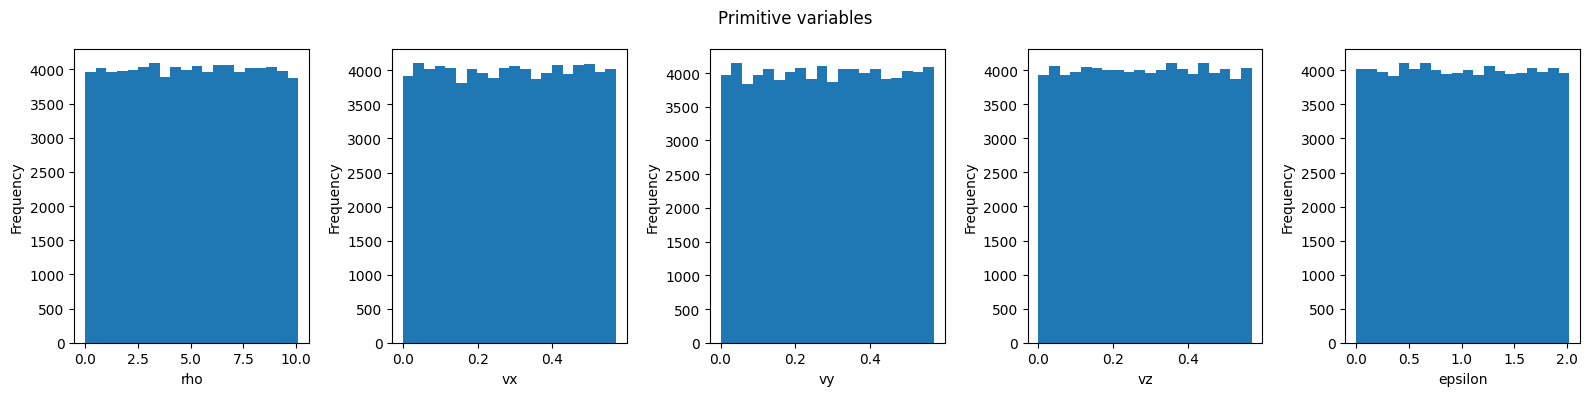

In [67]:
# Plotting the histograms of rho, vx and epsilon
plt.figure(figsize=(16, 4))
plt.subplot(1, 5, 1)
plt.hist(rho_train, bins=20)
plt.xlabel("rho")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.subplot(1, 5, 2)
plt.hist(vx_train, bins=20)
plt.xlabel("vx")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.subplot(1, 5, 3)
plt.hist(vy_train, bins=20)
plt.xlabel("vy")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.subplot(1, 5, 4)
plt.hist(vz_train, bins=20)
plt.xlabel("vz")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.subplot(1, 5, 5)
plt.hist(epsilon_train, bins=20)
plt.xlabel("epsilon")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.suptitle("Primitive variables")
plt.tight_layout()
plt.show()



In [68]:
%config InteractiveShell.ast_node_interactivity = "all"

In [69]:
# Generating the input and output data for train and test sets.
x_train = generate_input_data(rho_train, vx_train ,vy_train, vz_train, epsilon_train)
y_train = generate_labels(rho_train, epsilon_train) 
x_test = generate_input_data(rho_test, vx_test, vy_test, vz_test, epsilon_test)
y_test = generate_labels(rho_test, epsilon_test) 

In [70]:
x_train
y_train
x_test
y_test

tensor([[ 5.3518,  5.5407,  6.2987,  0.5088,  5.6678],
        [10.5083,  2.1281,  8.8768,  5.0672, 10.4496],
        [10.1694, 24.6210,  8.6734, 17.3371, 28.7775],
        ...,
        [ 4.4721,  2.5686,  0.6514,  7.2552,  7.7801],
        [ 1.6649,  3.8329,  2.9365,  2.0393,  5.2449],
        [10.0924,  7.4824,  5.1795,  0.5879, 12.0876]], device='cuda:0')

tensor([0.8612, 4.7430, 6.6911,  ..., 2.9883, 1.5751, 6.4734], device='cuda:0')

tensor([[ 9.4826,  2.1303,  3.8089,  0.1353,  2.8137],
        [ 3.2086,  0.2304,  0.0765,  1.0786,  4.0821],
        [ 1.0799,  5.0950,  4.3277,  4.3998,  7.4208],
        ...,
        [11.7645, 38.2826, 11.3023, 34.4865, 48.7155],
        [ 9.2215,  1.3869,  4.5133,  2.2089,  6.8695],
        [11.9479, 25.2658, 21.7815, 19.5978, 31.0534]], device='cuda:0')

tensor([1.2754, 2.6527, 0.6533,  ..., 8.3222, 3.8858, 2.5578], device='cuda:0')

In [71]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

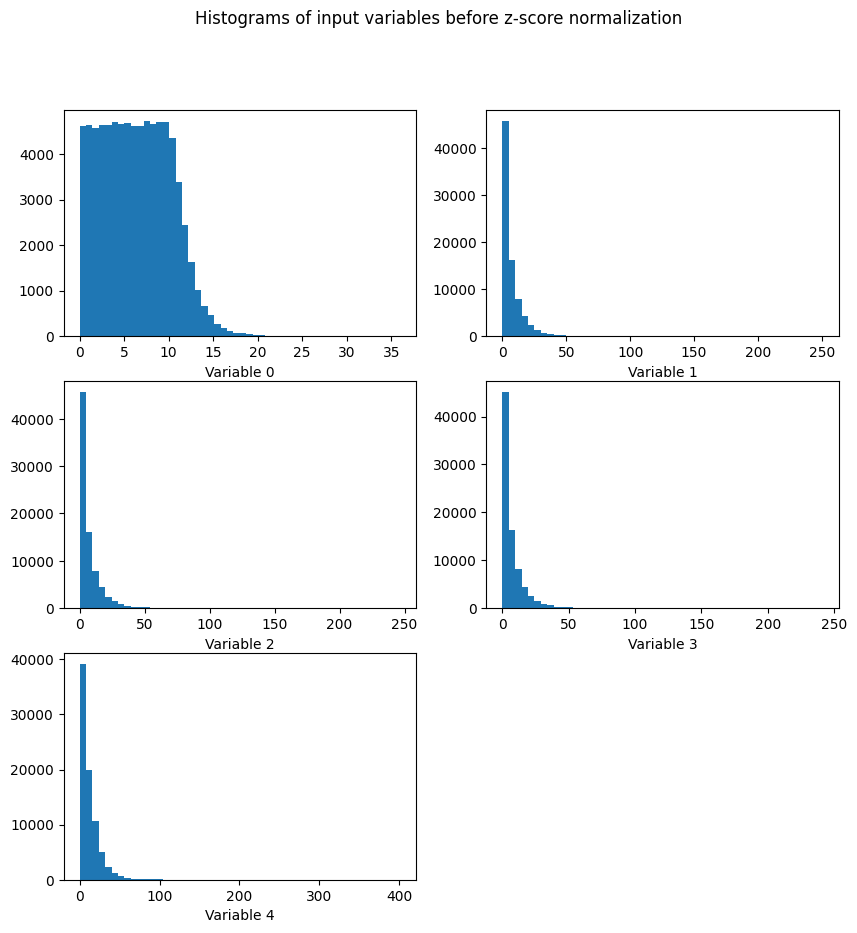

In [72]:
# Note how we are only plotting train and not test here. 
# Plotting histograms of the input variables before z-score normalization
plt.figure(figsize=(10, 10))
plt.suptitle('Histograms of input variables before z-score normalization')
for i in range(5):
    plt.subplot(3, 2, i+1)
    plt.hist(x_train[:, i].cpu(), bins=50) # Must be converted to cpu() for plotting.
    plt.xlabel(f'Variable {i}')
plt.show()


In [73]:
# print('Summary statistics of input variables before z-score normalization')
# print(torch.stack([torch.min(x_train, dim=0).values,
#                 torch.max(x_train, dim=0).values,
#                 torch.mean(x_train, dim=0),
#                 torch.median(x_train, dim=0).values,
#                 torch.std(x_train, dim=0)], dim=1))

# Computing summary statistics of the input variables before and after z-score normalization
print('Summary statistics of input variables before z-score normalization')
print(torch.stack([torch.min(x_train, dim=0).values, torch.max(x_train, dim=0).values, torch.nanmean(x_train, dim=0), torch.median(x_train, dim=0).values, torch.std(x_train, dim=0)], dim=1))

Summary statistics of input variables before z-score normalization
tensor([[6.6927e-05, 3.5973e+01, 6.3298e+00, 6.1996e+00, 3.8339e+00],
        [4.0428e-06, 2.5052e+02, 6.8724e+00, 3.8580e+00, 8.9550e+00],
        [1.2382e-06, 2.4635e+02, 6.8743e+00, 3.8543e+00, 8.9745e+00],
        [8.8250e-06, 2.4121e+02, 6.8453e+00, 3.8405e+00, 8.9339e+00],
        [1.6427e-05, 4.0075e+02, 1.2120e+01, 8.2927e+00, 1.3523e+01]],
       device='cuda:0')


Perform z-score normalization

In [74]:
%config InteractiveShell.ast_node_interactivity = "all"

In [75]:
if ZSCORE_NORMALIZATION:
    
    # # Computing the median of each input variable from the training set using torch.nanmedian function
    # D_median = torch.nanmedian(x_train[:, 0])
    # Sx_median = torch.nanmedian(x_train[:, 1])
    # Sy_median = torch.nanmedian(x_train[:, 2])
    # Sz_median = torch.nanmedian(x_train[:, 3])
    # tau_median = torch.nanmedian(x_train[:, 4])

    # # Computing the standard deviation of each input variable from the training set using torch.std function with a boolean mask to ignore nan values
    # D_std = torch.std(x_train[~torch.isnan(x_train[:, 0]), 0])
    # Sx_std = torch.std(x_train[~torch.isnan(x_train[:, 1]), 1])
    # Sy_std = torch.std(x_train[~torch.isnan(x_train[:, 2]), 2])
    # Sz_std = torch.std(x_train[~torch.isnan(x_train[:, 3]), 3])
    # tau_std = torch.std(x_train[~torch.isnan(x_train[:, 4]), 4])


    # # Applying z-score normalization to both train and test sets using the statistics from the training set
    # x_train[:, 0] = torch.sub(x_train[:, 0], D_median).div(D_std)
    # x_train[:, 1] = torch.sub(x_train[:, 1], Sx_median).div(Sx_std)
    # x_train[:, 2] = torch.sub(x_train[:, 2], Sy_median).div(Sy_std)
    # x_train[:, 3] = torch.sub(x_train[:, 3], Sz_median).div(Sz_std)
    # x_train[:, 4] = torch.sub(x_train[:, 4], tau_median).div(tau_std)

    # x_test[:, 0] = torch.sub(x_test[:, 0], D_median).div(D_std)
    # x_test[:, 1] = torch.sub(x_test[:, 1], Sx_median).div(Sx_std)
    # x_test[:, 2] = torch.sub(x_test[:, 2], Sy_median).div(Sy_std)
    # x_test[:, 3] = torch.sub(x_test[:, 3], Sz_median).div(Sz_std)
    # x_test[:, 4] = torch.sub(x_test[:, 4], tau_median).div(tau_std)

    # Computing the mean and standard deviation of each column
    mean = x_train.mean(dim=0)
    std = x_train.std(dim=0)

    # Applying z-score normalization
    x_train = (x_train - mean) / std
    # Use the same mean and std from the training data as we don't want test data leakage.
    x_test = (x_test - mean) / std



In [76]:
torch.__version__

'2.0.1+cu118'

In [77]:
x_train[:, 0]
x_train.shape
x_train
x_test

tensor([ 5.3518, 10.5083, 10.1694,  ...,  4.4721,  1.6649, 10.0924],
       device='cuda:0')

torch.Size([80000, 5])

tensor([[ 5.3518,  5.5407,  6.2987,  0.5088,  5.6678],
        [10.5083,  2.1281,  8.8768,  5.0672, 10.4496],
        [10.1694, 24.6210,  8.6734, 17.3371, 28.7775],
        ...,
        [ 4.4721,  2.5686,  0.6514,  7.2552,  7.7801],
        [ 1.6649,  3.8329,  2.9365,  2.0393,  5.2449],
        [10.0924,  7.4824,  5.1795,  0.5879, 12.0876]], device='cuda:0')

tensor([[ 9.4826,  2.1303,  3.8089,  0.1353,  2.8137],
        [ 3.2086,  0.2304,  0.0765,  1.0786,  4.0821],
        [ 1.0799,  5.0950,  4.3277,  4.3998,  7.4208],
        ...,
        [11.7645, 38.2826, 11.3023, 34.4865, 48.7155],
        [ 9.2215,  1.3869,  4.5133,  2.2089,  6.8695],
        [11.9479, 25.2658, 21.7815, 19.5978, 31.0534]], device='cuda:0')

Plotting the histograms of the input data after normalization if z-score normalization was performed.

In [78]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

In [79]:
if ZSCORE_NORMALIZATION: 
    # Note how we are only plotting train and not test here.
    # Plotting histograms of the input variables after z-score normalization
    plt.figure(figsize=(10, 10))
    plt.suptitle('Histograms of input variables after z-score normalization')
    for i in range(5):
        plt.subplot(3, 2, i+1)
        plt.hist(x_train[:, i].cpu(), bins=50) # Must be convertedhere to cpu() for plotting.
        plt.xlabel(f'Variable {i}')
    plt.show()

In [80]:
if ZSCORE_NORMALIZATION:
    # print('Summary statistics of input variables after z-score normalization')
    # print(torch.stack([torch.min(x_train, dim=0).values,
    #                 torch.max(x_train, dim=0).values,
    #                 torch.mean(x_train, dim=0),
    #                 torch.median(x_train, dim=0).values,
    #                 torch.std(x_train, dim=0)], dim=1))
    # Computing summary statistics of the input variables after z-score normalization
    print('Summary statistics of input variables after z-score normalization')
    print(torch.stack([torch.min(x_train, dim=0).values, torch.max(x_train, dim=0).values, torch.mean(x_train, dim=0), torch.median(x_train, dim=0).values, torch.std(x_train, dim=0)], dim=1))


Checking if our output is always positive by plotting a histogram of y_train and y_test tensors 

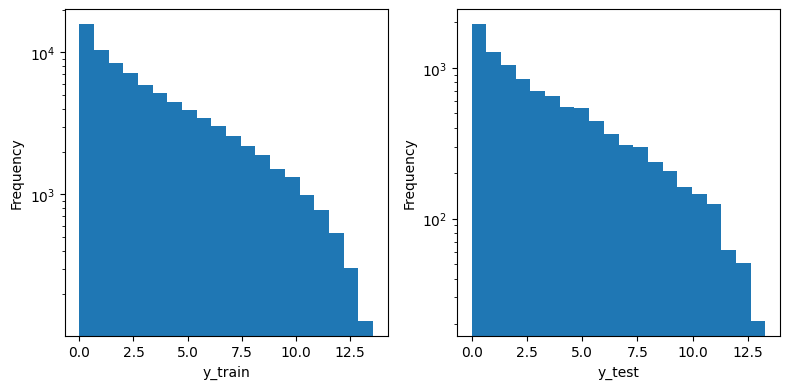

In [81]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(y_train.cpu().numpy(), bins=20) # must be cpu here.
plt.xlabel("y_train")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 2, 2)
plt.hist(y_test.cpu().numpy(), bins=20) # must be cpu here
plt.xlabel("y_test")
plt.ylabel("Frequency")
plt.yscale("log")
plt.tight_layout()
plt.show()


In [82]:
%config InteractiveShell.ast_node_interactivity = "all"

## Defining the neural network

In [83]:
# Defining a class for the network
class Net(nn.Module):
    """A class for creating a network with a
    variable number of hidden layers and units.

    Attributes:
        n_layers (int): The number of hidden layers in the network.
        n_units (list): A list of integers representing the number of units in each hidden layer.
        hidden_activation (torch.nn.Module): The activation function for the hidden layers.
        output_activation (torch.nn.Module): The activation function for the output layer.
        layers (torch.nn.ModuleList): A list of linear layers in the network.
    """

    def __init__(self, n_layers, n_units, hidden_activation, output_activation):
        """Initializes the network with the given hyperparameters.

        Args:
            n_layers (int): The number of hidden layers in the network.
            n_units (list): A list of integers representing the number of units in each hidden layer.
            hidden_activation (torch.nn.Module): The activation function for the hidden layers.
            output_activation (torch.nn.Module): The activation function for the output layer.
        """
        super().__init__()
        self.n_layers = n_layers
        self.n_units = n_units
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation

        # Creating a list of linear layers with different numbers of units for each layer
        self.layers = nn.ModuleList([nn.Linear(5, n_units[0])])
        for i in range(1, n_layers):
            self.layers.append(nn.Linear(n_units[i - 1], n_units[i]))
        self.layers.append(nn.Linear(n_units[-1], 1))

        # Adding some assertions to check that the input arguments are valid
        assert isinstance(n_layers, int) and n_layers > 0, "n_layers must be a positive integer"
        assert isinstance(n_units, list) and len(n_units) == n_layers, "n_units must be a list of length n_layers"
        assert all(isinstance(n, int) and n > 0 for n in n_units), "n_units must contain positive integers"
        assert isinstance(hidden_activation, nn.Module), "hidden_activation must be a torch.nn.Module"
        assert isinstance(output_activation, nn.Module), "output_activation must be a torch.nn.Module"

    def forward(self, x):
        """Performs a forward pass on the input tensor.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, 5).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, 1).
        """
        # Adding an assertion to check that the input tensor has the expected shape and type
        assert isinstance(x, torch.Tensor), "x must be a torch.Tensor"
        assert x.shape[1] == 5, "x must have shape (batch_size, 5)"

        # Looping over the hidden layers and applying the linear transformation and the activation function
        for layer in self.layers[:-1]:
            x = self.hidden_activation(layer(x))
        # Applying the linear transformation and the activation function on the output layer
        x = self.output_activation(self.layers[-1](x))

        # Returning the output tensor
        return x


## Defining the model and search space

In [84]:
# Defining a function to create a trial network and optimizer
def create_model(trial, optimize):
    """Creates a trial network and optimizer based on the sampled hyperparameters.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.
        optimize (boolean): Whether to optimize the hyperparameters or to use predefined values.

    Returns:
        tuple: A tuple of (net, loss_fn, optimizer, batch_size, n_epochs,
            scheduler, loss_name, optimizer_name, scheduler_name,
            n_units, n_layers, hidden_activation, output_activation),
            where net is the trial network,
            loss_fn is the loss function,
            optimizer is the optimizer,
            batch_size is the batch size,
            n_epochs is the number of epochs,
            scheduler is the learning rate scheduler,
            loss_name is the name of the loss function,
            optimizer_name is the name of the optimizer,
            scheduler_name is the name of the scheduler,
            n_units is a list of integers representing
            the number of units in each hidden layer,
            n_layers is an integer representing the number of hidden layers in the network,
            hidden_activation is a torch.nn.Module representing the activation function for the hidden layers,
            output_activation is a torch.nn.Module representing the activation function for the output layer,
            lr is the (initial) learning rate.
    """
    # If optimize is True, sample the hyperparameters from the search space
    if optimize:
        # Sampling the hyperparameters from the search space
        n_layers = trial.suggest_int("n_layers", 2, 6)
        n_units = [trial.suggest_int(f"n_units_{i}", 16, 2048) for i in range(n_layers)] 
        hidden_activation_name = trial.suggest_categorical(
            #"hidden_activation", ["ReLU", "LeakyReLU", "ELU", "Tanh", "Sigmoid"]
            #"hidden_activation", ["ReLU", "LeakyReLU"]
            "hidden_activation", ["ReLU", "LeakyReLU", "ELU"]
        )
        output_activation_name = trial.suggest_categorical(
            #"output_activation", ["Linear", "ReLU", "Softplus"]
            # Assuming pressure cannot be negative, linear output activation is not an option.
            #"output_activation", ["ReLU", "Softplus", "Linear"]
            "output_activation", ["ReLU", "Linear"]
        ) 
        loss_name = trial.suggest_categorical(
            #"loss", ["MSE", "MAE", "Huber", "LogCosh"] 
            "loss", ["MSE", "MAE", "Huber"] 
        )
        optimizer_name = trial.suggest_categorical(
            "optimizer", ["Adam", "SGD", "RMSprop", "Adagrad"] 
        )
        lr = trial.suggest_loguniform("lr", 1e-4, 1e-2) 

        batch_size_list = [32, 48, 64, 96, 128, 256, 512, 1048]
        batch_size = trial.suggest_categorical("batch_size", batch_size_list)
        #batch_size = trial.suggest_int("batch_size", 64, 1048)
        n_epochs = trial.suggest_int("n_epochs", 100, 300) 
        scheduler_name = trial.suggest_categorical(
            "scheduler",
            # ["None", "CosineAnnealingLR", "ReduceLROnPlateau", "StepLR", "ExponentialLR"],
            ["CosineAnnealingLR", "ReduceLROnPlateau", "StepLR"],
        )

    # If optimize is False, use the predefined values
    else:
        # Setting the hyperparameters to the predefined values
        n_layers = N_LAYERS_NO_OPT
        n_units = N_UNITS_NO_OPT
        hidden_activation_name = HIDDEN_ACTIVATION_NAME_NO_OPT
        output_activation_name = OUTPUT_ACTIVATION_NAME_NO_OPT
        loss_name = LOSS_NAME_NO_OPT
        optimizer_name = OPTIMIZER_NAME_NO_OPT
        lr = LR_NO_OPT
        batch_size = BATCH_SIZE_NO_OPT
        n_epochs = N_EPOCHS_NO_OPT
        scheduler_name = SCHEDULER_NAME_NO_OPT


    # Creating the activation functions from their names
    if hidden_activation_name == "ReLU":
        hidden_activation = nn.ReLU()
    elif hidden_activation_name == "LeakyReLU":
        hidden_activation = nn.LeakyReLU() 
    elif hidden_activation_name == "ELU":
        hidden_activation = nn.ELU() 
    elif hidden_activation_name == "Tanh":
        hidden_activation = nn.Tanh()
    else:
        hidden_activation = nn.Sigmoid()

    if output_activation_name == "ReLU":
        output_activation = nn.ReLU()
    elif output_activation_name == "Softplus":
        output_activation = nn.Softplus()
    else:
        output_activation = nn.Identity()

    # Creating the loss function from its name
    if loss_name == "MSE":
        loss_fn = nn.MSELoss()
    elif loss_name == "MAE":
        loss_fn = nn.L1Loss()
    elif loss_name == "Huber":
        loss_fn = nn.SmoothL1Loss() 
    else:
        # Creating the log-cosh loss function
        def log_cosh_loss(y_pred, y_true):
            return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
            
        loss_fn = log_cosh_loss

    # Creating the network with the sampled hyperparameters
    net = Net(
        n_layers, n_units, hidden_activation, output_activation
    ).to(device)

    if optimize:
        # Creating the optimizer from its name
        if optimizer_name == "SGD":
            # Added sampling the weight decay and momentum for SGD
            weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
            momentum = trial.suggest_uniform("momentum", 0.0, 0.99)
            optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
        elif optimizer_name == "Adam":
            # Added sampling the weight decay and beta parameters for Adam
            weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
            beta1 = trial.suggest_uniform("beta1", 0.9, 0.999)
            beta2 = trial.suggest_uniform("beta2", 0.999, 0.9999)
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
        else:
            # Added creating the Adagrad optimizer
            optimizer = optim.Adagrad(net.parameters(), lr=lr)

        # Creating the learning rate scheduler from its name
        if scheduler_name == "StepLR":
            step_size = trial.suggest_int("step_size", 5, 15)
            gamma = trial.suggest_uniform("gamma", 0.1, 0.5)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        elif scheduler_name == "ExponentialLR":
            gamma = trial.suggest_uniform("gamma", 0.8, 0.99)
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
        elif scheduler_name == "CosineAnnealingLR":
            if n_epochs < 150:
                t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.1, 0.3)
            elif n_epochs > 250:
                t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.05, 0.1)
            else:
                t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.1, 0.2)

            T_max = int(n_epochs * t_max_fraction)
            eta_min = trial.suggest_loguniform("eta_min", 1e-7, 1e-2)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
        elif scheduler_name == "ReduceLROnPlateau":
            # Added sampling the factor, patience and threshold for ReduceLROnPlateau
            factor = trial.suggest_uniform("factor", 0.1, 0.5)
            patience = trial.suggest_int("patience", 5, 10)
            threshold = trial.suggest_loguniform("threshold", 1e-4, 1e-2)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", factor=factor, patience=patience, threshold=threshold
            )
        # # Added using OneCycleLR scheduler as an option
        # elif scheduler_name == "OneCycleLR":
        #         # Added sampling the max_lr and pct_start for OneCycleLR
        #         max_lr = trial.suggest_loguniform("max_lr", lr, 10 * lr) 
        #         pct_start = trial.suggest_uniform("pct_start", 0.1, 0.9)
        #         scheduler = optim.lr_scheduler.OneCycleLR(
        #             optimizer,
        #             max_lr=max_lr,
        #             epochs=n_epochs,
        #             steps_per_epoch=len(train_loader),
        #             pct_start=pct_start,
        #         )
        else:
            scheduler = None
    else:
        # Creating the optimizer from its name
        if optimizer_name == "SGD":
            optimizer = optim.SGD(net.parameters(), lr=lr)
        elif optimizer_name == "Adam":
            optimizer = optim.Adam(net.parameters(), lr=lr)
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
        else:
            optimizer = optim.Adagrad(net.parameters(), lr=lr)

        # Creating the learning rate scheduler from its name
        if scheduler_name == "StepLR":
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        elif scheduler_name == "ExponentialLR":
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        elif scheduler_name == "CosineAnnealingLR":
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer)
        elif scheduler_name == "ReduceLROnPlateau":
            # Creating the ReduceLROnPlateau scheduler with a threshold value of 0.01
            #scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            #    optimizer, mode="min", factor=0.1, patience=10, threshold=0.01
            #)
            # Use Dieseldorst et al. settings and add to that a minimum lr.
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                        optimizer, mode="min", factor=0.18979341786654758, patience=11, threshold=0.0017197466122611932 #, min_lr=1e-6
                    )
        else:
            scheduler = None

    # Returning all variables needed for saving and loading
    return net, loss_fn, optimizer, batch_size, n_epochs, scheduler, loss_name, optimizer_name, scheduler_name, n_units, n_layers, hidden_activation, output_activation, lr



 ## The training and evaluation loop

 We first define a couple of functions used in the training and evaluation.

In [85]:
# Defining a function that computes loss and metrics for a given batch
def compute_loss_and_metrics(y_pred, y_true, loss_fn):
    """Computes loss and metrics for a given batch.

    Args:
        y_pred (torch.Tensor): The predicted pressure tensor of shape (batch_size, 1).
        y_true (torch.Tensor): The true pressure tensor of shape (batch_size,).
        loss_fn (torch.nn.Module or function): The loss function to use.

    Returns:
        tuple: A tuple of (loss, l1_norm), where loss is a scalar tensor,
            l1_norm is L1 norm for relative error of pressure,
            each being a scalar tensor.
            linf_norm is Linf norm for relative error of pressure.
    """
    # Reshaping the target tensor to match the input tensor
    y_true = y_true.view(-1, 1)

    # Computing the loss using the loss function
    loss = loss_fn(y_pred, y_true)

    # Computing the relative error of pressure
    rel_error = torch.abs((y_pred - y_true) / y_true)

    # Computing the L1 norm for the relative error of pressure
    l1_norm = torch.mean(rel_error) 
    # Computing the Linf norm for the relative error of pressure
    linf_norm = torch.max(rel_error) 

    # Returning the loss and metrics
    return loss, l1_norm, linf_norm


# Defining a function that updates the learning rate scheduler with validation loss if applicable
def update_scheduler(scheduler, test_loss):
    """Updates the learning rate scheduler with validation loss if applicable.

    Args:
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler to use.
        test_loss (float): The validation loss to use.

    Returns:
        None
    """
    # Checking if scheduler is not None
    if scheduler is not None:
        # Checking if scheduler is ReduceLROnPlateau
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            # Updating the scheduler with test_loss
            scheduler.step(test_loss)
        else:
            # Updating the scheduler without test_loss
            scheduler.step()


Now for the actual training and evaluation loop,

In [86]:
# Defining a function to train and evaluate a network
def train_and_eval(net, loss_fn, optimizer, batch_size, n_epochs, scheduler, trial=None):
    """Trains and evaluates a network.

    Args:
        net (torch.nn.Module): The network to train and evaluate.
        loss_fn (torch.nn.Module or function): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        batch_size (int): The batch size.
        n_epochs (int): The number of epochs.
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler.
    Returns:
        tuple: A tuple of (train_losses, test_losses, train_metrics, test_metrics), where
            train_losses is a list of training losses for each epoch,
            test_losses is a list of validation losses for each epoch,
            train_metrics is a list of dictionaries containing training metrics for each epoch,
            test_metrics is a list of dictionaries containing validation metrics for each epoch.
    """
    # Creating data loaders for train and test sets
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size
    )

    # Initializing lists to store the losses and metrics for each epoch
    train_losses = []
    test_losses = []
    train_metrics = []
    test_metrics = []

    # Creating a SummaryWriter object to log data for tensorboard
    writer = tbx.SummaryWriter()

    # Looping over the epochs
    for epoch in range(n_epochs):

        # Setting the network to training mode
        net.train()

        # Initializing variables to store the total loss and metrics for the train set
        train_loss = 0.0
        train_l1_norm = 0.0
        train_linf_norm = 0.0

        # Looping over the batches in the train set
        for x_batch, y_batch in train_loader:

            # Moving the batch tensors to the device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Zeroing the gradients
            optimizer.zero_grad()

            # Performing a forward pass and computing the loss and metrics
            y_pred = net(x_batch)
            loss, l1_norm, linf_norm = compute_loss_and_metrics(
                y_pred, y_batch, loss_fn
            )


            # Performing a backward pass and updating the weights
            loss.backward()
            optimizer.step()

            # Updating the total loss and metrics for the train set
            train_loss += loss.item() * x_batch.size(0)
            train_l1_norm += l1_norm.item() * x_batch.size(0)
            train_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the train set
        train_loss /= len(train_loader.dataset)
        train_l1_norm /= len(train_loader.dataset)
        train_linf_norm /= len(train_loader.dataset)

        # Appending the average loss and metrics for the train set to the lists
        train_losses.append(train_loss)
        train_metrics.append(
            {
                "l1_norm": train_l1_norm,
                "linf_norm": train_linf_norm,
            }
        )

        # Logging the average loss and metrics for the train set to tensorboard
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("L1 norm/train", train_l1_norm, epoch)
        writer.add_scalar("Linf norm/train", train_linf_norm, epoch)

        # Setting the network to evaluation mode
        net.eval()

        # Initializing variables to store the total loss and metrics for the test set
        test_loss = 0.0
        test_l1_norm = 0.0
        test_linf_norm = 0.0

        # Looping over the batches in the test set
        with torch.no_grad():
            for x_batch, y_batch in test_loader:

                # Moving the batch tensors to the device
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                # Performing a forward pass and computing the loss and metrics
                y_pred = net(x_batch)
                loss, l1_norm, linf_norm = compute_loss_and_metrics(
                    y_pred, y_batch, loss_fn
                )


                # Updating the total loss and metrics for the test set
                test_loss += loss.item() * x_batch.size(0)
                test_l1_norm += l1_norm.item() * x_batch.size(0)
                test_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the test set
        test_loss /= len(test_loader.dataset)
        test_l1_norm /= len(test_loader.dataset)
        test_linf_norm /= len(test_loader.dataset)

        # Appending the average loss and metrics for the test set to the lists
        test_losses.append(test_loss)
        test_metrics.append(
            {
                "l1_norm": test_l1_norm,
                "linf_norm": test_linf_norm,
            }
        )

        # Logging the average loss and metrics for the test set to tensorboard
        writer.add_scalar("Loss/test", test_loss, epoch)
        writer.add_scalar("L1 norm/test", test_l1_norm, epoch)
        writer.add_scalar("Linf norm/test", test_linf_norm, epoch)

        # Printing the average loss and metrics for both sets for this epoch
        print(
            f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
            f"Train L1 Norm: {train_l1_norm:.4f}, Test L1 Norm: {test_l1_norm:.4f}, "
            f"Train Linf Norm: {train_linf_norm:.4f}, Test Linf Norm: {test_linf_norm:.4f}"
        )

        # Updating the learning rate scheduler with validation loss if applicable
        update_scheduler(scheduler, test_loss)

        # Reporting the intermediate metric value to Optuna if trial is not None
        if trial is not None:
            trial.report(test_metrics[-1]["l1_norm"], epoch)

            # Checking if the trial should be pruned based on the intermediate value if trial is not None
            if trial.should_prune():
                raise optuna.TrialPruned()

    # Closing the SummaryWriter object
    writer.close()

    # Returning the losses and metrics lists
    return train_losses, test_losses, train_metrics, test_metrics

## The objective function and hyperparameter tuning

In [87]:
# Defining an objective function for Optuna to minimize
def objective(trial):
    """Defines an objective function for Optuna to minimize.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.

    Returns:
        float: The validation L1 norm to minimize.
    """
    # Creating a trial network and optimizer using the create_model function
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial, optimize=True)

    # Training and evaluating the network using the train_and_eval function
    _, _, _, test_metrics = train_and_eval(
        net, loss_fn, optimizer, batch_size, n_epochs, scheduler, trial
    )

    # Returning the last validation L1 norm as the objective value to minimize
    return test_metrics[-1]["l1_norm"]

In [ ]:
if OPTIMIZE:
    # Creating a study object with Optuna with TPE sampler and median pruner 
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())

    # Running Optuna with 100 trials when we are optimizing.
    study.optimize(objective, n_trials=N_TRIALS)

    # Printing the best trial information
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


[I 2023-05-21 09:59:14,149] A new study created in memory with name: no-name-736a4f99-2495-425b-b24d-e63883b1fada
<ipython-input-84-e8f6ba3279cc>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
<ipython-input-84-e8f6ba3279cc>:121: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
<ipython-input-84-e8f6ba3279cc>:122: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  mom

Epoch 1: Train Loss: 0.4420, Test Loss: 0.1745, Train L1 Norm: 0.3532, Test L1 Norm: 0.1043, Train Linf Norm: 9.5836, Test Linf Norm: 0.9691
Epoch 2: Train Loss: 0.1889, Test Loss: 0.0520, Train L1 Norm: 0.1642, Test L1 Norm: 0.0438, Train Linf Norm: 4.9070, Test Linf Norm: 0.9201
Epoch 3: Train Loss: 0.1627, Test Loss: 0.2275, Train L1 Norm: 0.1389, Test L1 Norm: 0.1331, Train Linf Norm: 4.1283, Test Linf Norm: 2.1668
Epoch 4: Train Loss: 0.1509, Test Loss: 0.1073, Train L1 Norm: 0.1289, Test L1 Norm: 0.0532, Train Linf Norm: 3.9471, Test Linf Norm: 0.7232
Epoch 5: Train Loss: 0.1430, Test Loss: 0.1072, Train L1 Norm: 0.1055, Test L1 Norm: 0.0701, Train Linf Norm: 2.7631, Test Linf Norm: 0.8141
Epoch 6: Train Loss: 0.1321, Test Loss: 0.2095, Train L1 Norm: 0.1046, Test L1 Norm: 0.0960, Train Linf Norm: 3.0164, Test Linf Norm: 1.2267
Epoch 7: Train Loss: 0.1260, Test Loss: 0.3000, Train L1 Norm: 0.0932, Test L1 Norm: 0.1262, Train Linf Norm: 2.4621, Test Linf Norm: 0.9018
Epoch 8: Trai

[I 2023-05-21 10:14:07,549] Trial 0 finished with value: 0.012935786840319633 and parameters: {'n_layers': 2, 'n_units_0': 773, 'n_units_1': 1987, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'SGD', 'lr': 0.00040663822157222863, 'batch_size': 64, 'n_epochs': 289, 'scheduler': 'ReduceLROnPlateau', 'weight_decay': 1.029492206702847e-05, 'momentum': 0.5516991905726143, 'factor': 0.26653830096536435, 'patience': 6, 'threshold': 0.0032203718974128173}. Best is trial 0 with value: 0.012935786840319633.


Epoch 289: Train Loss: 0.0062, Test Loss: 0.0065, Train L1 Norm: 0.0257, Test L1 Norm: 0.0129, Train Linf Norm: 1.2079, Test Linf Norm: 0.3982


<ipython-input-84-e8f6ba3279cc>:139: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.1, 0.5)


Epoch 1: Train Loss: 2.9463, Test Loss: 2.9669, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 2: Train Loss: 2.9463, Test Loss: 2.9669, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 2.9463, Test Loss: 2.9669, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 4: Train Loss: 2.9463, Test Loss: 2.9669, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 5: Train Loss: 2.9463, Test Loss: 2.9669, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 6: Train Loss: 2.9463, Test Loss: 2.9669, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 7: Train Loss: 2.9463, Test Loss: 2.9669, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 8: Trai

[I 2023-05-21 10:20:07,998] Trial 1 finished with value: 1.0 and parameters: {'n_layers': 5, 'n_units_0': 1560, 'n_units_1': 445, 'n_units_2': 446, 'n_units_3': 856, 'n_units_4': 294, 'hidden_activation': 'ELU', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'SGD', 'lr': 0.00010388994522070564, 'batch_size': 256, 'n_epochs': 237, 'scheduler': 'StepLR', 'weight_decay': 0.00010395519123365011, 'momentum': 0.10034993433961172, 'step_size': 10, 'gamma': 0.41148736160061095}. Best is trial 0 with value: 0.012935786840319633.


Epoch 237: Train Loss: 2.9463, Test Loss: 2.9669, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.8425, Test Loss: 0.0440, Train L1 Norm: 0.9844, Test L1 Norm: 0.1463, Train Linf Norm: 179.7404, Test Linf Norm: 11.9432
Epoch 2: Train Loss: 0.0492, Test Loss: 0.0157, Train L1 Norm: 0.3748, Test L1 Norm: 0.0977, Train Linf Norm: 71.6290, Test Linf Norm: 10.1464
Epoch 3: Train Loss: 0.0298, Test Loss: 0.3998, Train L1 Norm: 0.4403, Test L1 Norm: 0.3348, Train Linf Norm: 91.9617, Test Linf Norm: 23.2713
Epoch 4: Train Loss: 0.0207, Test Loss: 0.1253, Train L1 Norm: 0.3794, Test L1 Norm: 0.1792, Train Linf Norm: 81.6216, Test Linf Norm: 12.5125
Epoch 5: Train Loss: 0.0156, Test Loss: 0.0022, Train L1 Norm: 0.1969, Test L1 Norm: 0.0470, Train Linf Norm: 38.6883, Test Linf Norm: 4.6816
Epoch 6: Train Loss: 0.0062, Test Loss: 0.0014, Train L1 Norm: 0.1158, Test L1 Norm: 0.0392, Train Linf Norm: 20.8593, Test Linf Norm: 3.7451


[I 2023-05-21 10:30:29,046] Trial 2 finished with value: 0.02124303916990757 and parameters: {'n_layers': 5, 'n_units_0': 1386, 'n_units_1': 1792, 'n_units_2': 1561, 'n_units_3': 1842, 'n_units_4': 1676, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.00033404928260473296, 'batch_size': 256, 'n_epochs': 198, 'scheduler': 'StepLR', 'step_size': 12, 'gamma': 0.14980746595541447}. Best is trial 0 with value: 0.012935786840319633.


Epoch 198: Train Loss: 0.0004, Test Loss: 0.0004, Train L1 Norm: 0.0574, Test L1 Norm: 0.0212, Train Linf Norm: 10.3678, Test Linf Norm: 1.8110


<ipython-input-84-e8f6ba3279cc>:126: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
<ipython-input-84-e8f6ba3279cc>:127: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  beta1 = trial.suggest_uniform("beta1", 0.9, 0.999)
<ipython-input-84-e8f6ba3279cc>:128: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  beta2 = trial.suggest_uniform("beta2", 0.999, 0.9999)


Epoch 1: Train Loss: 0.1904, Test Loss: 0.0429, Train L1 Norm: 0.5185, Test L1 Norm: 0.1065, Train Linf Norm: 35.9589, Test Linf Norm: 5.5928
Epoch 2: Train Loss: 0.0678, Test Loss: 0.0504, Train L1 Norm: 0.1704, Test L1 Norm: 0.0849, Train Linf Norm: 11.3630, Test Linf Norm: 3.9682
Epoch 3: Train Loss: 0.0531, Test Loss: 0.0530, Train L1 Norm: 0.2209, Test L1 Norm: 0.0966, Train Linf Norm: 17.0274, Test Linf Norm: 4.7207
Epoch 4: Train Loss: 0.0599, Test Loss: 0.0603, Train L1 Norm: 0.2638, Test L1 Norm: 0.0666, Train Linf Norm: 20.7252, Test Linf Norm: 2.6924
Epoch 5: Train Loss: 0.0434, Test Loss: 0.0385, Train L1 Norm: 0.1714, Test L1 Norm: 0.0605, Train Linf Norm: 12.8915, Test Linf Norm: 2.4305
Epoch 6: Train Loss: 0.0548, Test Loss: 0.0397, Train L1 Norm: 0.1393, Test L1 Norm: 0.0412, Train Linf Norm: 9.1372, Test Linf Norm: 1.4406
Epoch 7: Train Loss: 0.0530, Test Loss: 0.0313, Train L1 Norm: 0.2141, Test L1 Norm: 0.0537, Train Linf Norm: 16.8206, Test Linf Norm: 2.4414
Epoch 8

[I 2023-05-21 10:39:12,562] Trial 3 finished with value: 0.028977795132249594 and parameters: {'n_layers': 4, 'n_units_0': 424, 'n_units_1': 897, 'n_units_2': 1291, 'n_units_3': 138, 'hidden_activation': 'ELU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00020202474019662773, 'batch_size': 96, 'n_epochs': 175, 'scheduler': 'ReduceLROnPlateau', 'weight_decay': 0.004113904559939576, 'beta1': 0.9847833120865573, 'beta2': 0.9995619130347876, 'factor': 0.37020334279924105, 'patience': 8, 'threshold': 0.0012516298501235883}. Best is trial 0 with value: 0.012935786840319633.


Epoch 175: Train Loss: 0.0073, Test Loss: 0.0073, Train L1 Norm: 0.1158, Test L1 Norm: 0.0290, Train Linf Norm: 9.5672, Test Linf Norm: 1.4303
Epoch 1: Train Loss: 21.1528, Test Loss: 20.6405, Train L1 Norm: 1.0212, Test L1 Norm: 1.0000, Train Linf Norm: 1.5744, Test Linf Norm: 1.0000
Epoch 2: Train Loss: 20.5565, Test Loss: 20.6405, Train L1 Norm: 1.0524, Test L1 Norm: 1.0000, Train Linf Norm: 5.8520, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 20.4332, Test Loss: 20.6405, Train L1 Norm: 1.0000, Test L1 Norm: 0.9997, Train Linf Norm: 1.0383, Test Linf Norm: 1.0029
Epoch 4: Train Loss: 20.4332, Test Loss: 20.6405, Train L1 Norm: 1.1711, Test L1 Norm: 1.1196, Train Linf Norm: 17.5175, Test Linf Norm: 12.4808
Epoch 5: Train Loss: 20.4333, Test Loss: 20.6405, Train L1 Norm: 4.7914, Test L1 Norm: 1.2145, Train Linf Norm: 362.9899, Test Linf Norm: 21.3932
Epoch 6: Train Loss: 20.4333, Test Loss: 20.6405, Train L1 Norm: 3.9837, Test L1 Norm: 1.2289, Train Linf Norm: 285.5290, Test Linf Norm:

[I 2023-05-21 10:50:27,307] Trial 4 finished with value: 0.30045639176368716 and parameters: {'n_layers': 3, 'n_units_0': 696, 'n_units_1': 1895, 'n_units_2': 1569, 'hidden_activation': 'ELU', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 0.0008409600460964214, 'batch_size': 96, 'n_epochs': 178, 'scheduler': 'ReduceLROnPlateau', 'weight_decay': 0.002240699477743407, 'beta1': 0.9025981352990071, 'beta2': 0.9995581573861478, 'factor': 0.39905339110195304, 'patience': 9, 'threshold': 0.0040278834744635035}. Best is trial 0 with value: 0.012935786840319633.


Epoch 178: Train Loss: 0.4384, Test Loss: 0.4216, Train L1 Norm: 0.3008, Test L1 Norm: 0.3005, Train Linf Norm: 4.3498, Test Linf Norm: 4.3647


<ipython-input-84-e8f6ba3279cc>:148: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.05, 0.1)
<ipython-input-84-e8f6ba3279cc>:153: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  eta_min = trial.suggest_loguniform("eta_min", 1e-7, 1e-2)
[I 2023-05-21 10:50:36,873] Trial 5 pruned. 


Epoch 1: Train Loss: 0.1079, Test Loss: 0.0056, Train L1 Norm: 2.1395, Test L1 Norm: 0.3547, Train Linf Norm: 63.0990, Test Linf Norm: 9.2812


[I 2023-05-21 10:50:38,492] Trial 6 pruned. 


Epoch 1: Train Loss: 7.5595, Test Loss: 0.0269, Train L1 Norm: 2.8117, Test L1 Norm: 0.2679, Train Linf Norm: 1030.0729, Test Linf Norm: 38.7594


<ipython-input-84-e8f6ba3279cc>:150: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.1, 0.2)
[I 2023-05-21 10:50:43,652] Trial 7 pruned. 


Epoch 1: Train Loss: 450.0821, Test Loss: 20.6405, Train L1 Norm: 1.1590, Test L1 Norm: 1.0000, Train Linf Norm: 1.4608, Test Linf Norm: 1.0000


<ipython-input-84-e8f6ba3279cc>:146: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.1, 0.3)
[I 2023-05-21 10:50:47,247] Trial 8 pruned. 


Epoch 1: Train Loss: 0.2177, Test Loss: 0.1897, Train L1 Norm: 3.0303, Test L1 Norm: 0.6047, Train Linf Norm: 174.9908, Test Linf Norm: 23.2419


[I 2023-05-21 10:50:49,565] Trial 9 pruned. 


Epoch 1: Train Loss: 625.8397, Test Loss: 1.2418, Train L1 Norm: 735.2398, Test L1 Norm: 2.3743, Train Linf Norm: 33342.7238, Test Linf Norm: 124.9416


[I 2023-05-21 10:50:52,447] Trial 10 pruned. 


Epoch 1: Train Loss: 1.4544, Test Loss: 1.1655, Train L1 Norm: 3.1942, Test L1 Norm: 0.9896, Train Linf Norm: 158.9673, Test Linf Norm: 27.8242
Epoch 1: Train Loss: 0.3784, Test Loss: 0.1645, Train L1 Norm: 0.4081, Test L1 Norm: 0.1391, Train Linf Norm: 30.7157, Test Linf Norm: 6.1108
Epoch 2: Train Loss: 0.1435, Test Loss: 0.0706, Train L1 Norm: 0.1217, Test L1 Norm: 0.0464, Train Linf Norm: 7.5051, Test Linf Norm: 1.7247
Epoch 3: Train Loss: 0.1035, Test Loss: 0.0898, Train L1 Norm: 0.1015, Test L1 Norm: 0.0605, Train Linf Norm: 7.1415, Test Linf Norm: 2.1996
Epoch 4: Train Loss: 0.0847, Test Loss: 0.1047, Train L1 Norm: 0.1189, Test L1 Norm: 0.0414, Train Linf Norm: 10.4224, Test Linf Norm: 0.6073
Epoch 5: Train Loss: 0.0733, Test Loss: 0.0828, Train L1 Norm: 0.0573, Test L1 Norm: 0.0348, Train Linf Norm: 3.2126, Test Linf Norm: 0.5417
Epoch 6: Train Loss: 0.0653, Test Loss: 0.0627, Train L1 Norm: 0.0736, Test L1 Norm: 0.0328, Train Linf Norm: 5.6921, Test Linf Norm: 0.5947
Epoch 7:

[I 2023-05-21 11:04:50,831] Trial 11 finished with value: 0.0071948581174016 and parameters: {'n_layers': 6, 'n_units_0': 1992, 'n_units_1': 2040, 'n_units_2': 2042, 'n_units_3': 2029, 'n_units_4': 2047, 'n_units_5': 125, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.00032125573031380997, 'batch_size': 128, 'n_epochs': 140, 'scheduler': 'StepLR', 'step_size': 15, 'gamma': 0.10437837591079809}. Best is trial 11 with value: 0.0071948581174016.


Epoch 140: Train Loss: 0.0074, Test Loss: 0.0076, Train L1 Norm: 0.0152, Test L1 Norm: 0.0072, Train Linf Norm: 1.3142, Test Linf Norm: 0.2953
Epoch 1: Train Loss: 0.3610, Test Loss: 0.1684, Train L1 Norm: 0.2644, Test L1 Norm: 0.0923, Train Linf Norm: 13.2622, Test Linf Norm: 2.8625
Epoch 2: Train Loss: 0.1261, Test Loss: 0.0658, Train L1 Norm: 0.1094, Test L1 Norm: 0.0399, Train Linf Norm: 6.7323, Test Linf Norm: 1.4362
Epoch 3: Train Loss: 0.0925, Test Loss: 0.1111, Train L1 Norm: 0.0864, Test L1 Norm: 0.0659, Train Linf Norm: 5.6650, Test Linf Norm: 2.1000
Epoch 4: Train Loss: 0.0746, Test Loss: 0.0855, Train L1 Norm: 0.0601, Test L1 Norm: 0.0589, Train Linf Norm: 3.2431, Test Linf Norm: 2.3152
Epoch 5: Train Loss: 0.0652, Test Loss: 0.0516, Train L1 Norm: 0.0612, Test L1 Norm: 0.0269, Train Linf Norm: 4.0097, Test Linf Norm: 0.5396
Epoch 6: Train Loss: 0.0588, Test Loss: 0.0415, Train L1 Norm: 0.0605, Test L1 Norm: 0.0293, Train Linf Norm: 4.2847, Test Linf Norm: 1.1892
Epoch 7: T

[I 2023-05-21 11:11:56,444] Trial 12 finished with value: 0.00870779783502221 and parameters: {'n_layers': 6, 'n_units_0': 1936, 'n_units_1': 1502, 'n_units_2': 824, 'n_units_3': 1432, 'n_units_4': 1988, 'n_units_5': 128, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.000301133676971451, 'batch_size': 128, 'n_epochs': 110, 'scheduler': 'StepLR', 'step_size': 15, 'gamma': 0.10762289665402752}. Best is trial 11 with value: 0.0071948581174016.


Epoch 110: Train Loss: 0.0092, Test Loss: 0.0096, Train L1 Norm: 0.0198, Test L1 Norm: 0.0087, Train Linf Norm: 1.7362, Test Linf Norm: 0.3312
Epoch 1: Train Loss: 0.3128, Test Loss: 0.1368, Train L1 Norm: 0.2607, Test L1 Norm: 0.0634, Train Linf Norm: 14.2745, Test Linf Norm: 1.0677
Epoch 2: Train Loss: 0.0951, Test Loss: 0.0612, Train L1 Norm: 0.0878, Test L1 Norm: 0.0464, Train Linf Norm: 5.2356, Test Linf Norm: 1.8048
Epoch 3: Train Loss: 0.0679, Test Loss: 0.0651, Train L1 Norm: 0.0658, Test L1 Norm: 0.0423, Train Linf Norm: 3.9767, Test Linf Norm: 1.4081
Epoch 4: Train Loss: 0.0559, Test Loss: 0.0573, Train L1 Norm: 0.0803, Test L1 Norm: 0.0332, Train Linf Norm: 6.6312, Test Linf Norm: 0.7136
Epoch 5: Train Loss: 0.0482, Test Loss: 0.0435, Train L1 Norm: 0.0845, Test L1 Norm: 0.0318, Train Linf Norm: 7.5609, Test Linf Norm: 1.1066
Epoch 6: Train Loss: 0.0427, Test Loss: 0.0400, Train L1 Norm: 0.0702, Test L1 Norm: 0.0245, Train Linf Norm: 6.1050, Test Linf Norm: 0.6618
Epoch 7: T

[I 2023-05-21 11:18:28,751] Trial 13 finished with value: 0.012574341285228729 and parameters: {'n_layers': 6, 'n_units_0': 1944, 'n_units_1': 1471, 'n_units_2': 100, 'n_units_3': 1415, 'n_units_4': 2040, 'n_units_5': 133, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0001372855975549327, 'batch_size': 128, 'n_epochs': 111, 'scheduler': 'StepLR', 'step_size': 15, 'gamma': 0.11511660244492616}. Best is trial 11 with value: 0.0071948581174016.


Epoch 111: Train Loss: 0.0107, Test Loss: 0.0108, Train L1 Norm: 0.0295, Test L1 Norm: 0.0126, Train Linf Norm: 2.6068, Test Linf Norm: 0.4736
Epoch 1: Train Loss: 0.3205, Test Loss: 0.1388, Train L1 Norm: 0.4714, Test L1 Norm: 0.0660, Train Linf Norm: 40.0678, Test Linf Norm: 1.0579


[I 2023-05-21 11:18:37,250] Trial 14 pruned. 


Epoch 2: Train Loss: 0.1136, Test Loss: 0.1063, Train L1 Norm: 0.1074, Test L1 Norm: 0.0781, Train Linf Norm: 6.7136, Test Linf Norm: 3.0385


[I 2023-05-21 11:18:48,771] Trial 15 pruned. 


Epoch 1: Train Loss: 3.3922, Test Loss: 3.4125, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.3285, Test Loss: 0.1097, Train L1 Norm: 0.4904, Test L1 Norm: 0.0589, Train Linf Norm: 41.7599, Test Linf Norm: 1.6510
Epoch 2: Train Loss: 0.0958, Test Loss: 0.0758, Train L1 Norm: 0.1089, Test L1 Norm: 0.0400, Train Linf Norm: 7.7079, Test Linf Norm: 0.8012
Epoch 3: Train Loss: 0.0680, Test Loss: 0.0547, Train L1 Norm: 0.1015, Test L1 Norm: 0.0449, Train Linf Norm: 8.4925, Test Linf Norm: 1.8738
Epoch 4: Train Loss: 0.0548, Test Loss: 0.0566, Train L1 Norm: 0.0667, Test L1 Norm: 0.0326, Train Linf Norm: 4.8547, Test Linf Norm: 0.6153
Epoch 5: Train Loss: 0.0468, Test Loss: 0.0349, Train L1 Norm: 0.0643, Test L1 Norm: 0.0227, Train Linf Norm: 5.0170, Test Linf Norm: 0.6459
Epoch 6: Train Loss: 0.0413, Test Loss: 0.0543, Train L1 Norm: 0.0536, Test L1 Norm: 0.0277, Train Linf Norm: 3.9909, Test Linf Norm: 0.5362
Epoch 7: Tra

[I 2023-05-21 11:25:20,107] Trial 16 finished with value: 0.011224059377610684 and parameters: {'n_layers': 6, 'n_units_0': 2042, 'n_units_1': 1243, 'n_units_2': 937, 'n_units_3': 2029, 'n_units_4': 436, 'n_units_5': 533, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.00010004922522277522, 'batch_size': 128, 'n_epochs': 106, 'scheduler': 'StepLR', 'step_size': 12, 'gamma': 0.23343121945561063}. Best is trial 11 with value: 0.0071948581174016.


Epoch 106: Train Loss: 0.0095, Test Loss: 0.0096, Train L1 Norm: 0.0305, Test L1 Norm: 0.0112, Train Linf Norm: 2.8594, Test Linf Norm: 0.4440


[I 2023-05-21 11:25:22,040] Trial 17 pruned. 


Epoch 1: Train Loss: 0.8018, Test Loss: 0.4206, Train L1 Norm: 0.8756, Test L1 Norm: 0.3213, Train Linf Norm: 377.2215, Test Linf Norm: 42.9503


[I 2023-05-21 11:25:26,477] Trial 18 pruned. 


Epoch 1: Train Loss: 3.3922, Test Loss: 3.4125, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-21 11:25:29,409] Trial 19 pruned. 


Epoch 1: Train Loss: 3.4440, Test Loss: 3.4125, Train L1 Norm: 1.1393, Test L1 Norm: 1.0000, Train Linf Norm: 15.1420, Test Linf Norm: 1.0000


[I 2023-05-21 11:25:30,922] Trial 20 pruned. 


Epoch 1: Train Loss: 0.7232, Test Loss: 0.4564, Train L1 Norm: 0.9060, Test L1 Norm: 0.1769, Train Linf Norm: 254.2427, Test Linf Norm: 8.0636
Epoch 1: Train Loss: 0.3375, Test Loss: 0.1395, Train L1 Norm: 0.3684, Test L1 Norm: 0.0657, Train Linf Norm: 24.7821, Test Linf Norm: 1.3027
Epoch 2: Train Loss: 0.0969, Test Loss: 0.0713, Train L1 Norm: 0.0938, Test L1 Norm: 0.0404, Train Linf Norm: 5.7938, Test Linf Norm: 1.0166
Epoch 3: Train Loss: 0.0673, Test Loss: 0.0598, Train L1 Norm: 0.0722, Test L1 Norm: 0.0452, Train Linf Norm: 4.7528, Test Linf Norm: 1.7307
Epoch 4: Train Loss: 0.0555, Test Loss: 0.0473, Train L1 Norm: 0.0682, Test L1 Norm: 0.0289, Train Linf Norm: 4.9707, Test Linf Norm: 0.8101
Epoch 5: Train Loss: 0.0467, Test Loss: 0.0545, Train L1 Norm: 0.0596, Test L1 Norm: 0.0306, Train Linf Norm: 4.2258, Test Linf Norm: 0.7268
Epoch 6: Train Loss: 0.0425, Test Loss: 0.0456, Train L1 Norm: 0.0521, Test L1 Norm: 0.0385, Train Linf Norm: 3.6865, Test Linf Norm: 1.6381
Epoch 7: T

[I 2023-05-21 11:32:58,973] Trial 21 finished with value: 0.011723011416196824 and parameters: {'n_layers': 6, 'n_units_0': 2043, 'n_units_1': 1325, 'n_units_2': 979, 'n_units_3': 2008, 'n_units_4': 239, 'n_units_5': 341, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0001069357396592891, 'batch_size': 128, 'n_epochs': 123, 'scheduler': 'StepLR', 'step_size': 13, 'gamma': 0.22839255793674637}. Best is trial 11 with value: 0.0071948581174016.


Epoch 123: Train Loss: 0.0095, Test Loss: 0.0096, Train L1 Norm: 0.0254, Test L1 Norm: 0.0117, Train Linf Norm: 2.2216, Test Linf Norm: 0.5159


[I 2023-05-21 11:33:02,744] Trial 22 pruned. 


Epoch 1: Train Loss: 3.3922, Test Loss: 3.4125, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.3484, Test Loss: 0.2017, Train L1 Norm: 0.3755, Test L1 Norm: 0.0822, Train Linf Norm: 27.8196, Test Linf Norm: 1.4597


[I 2023-05-21 11:33:10,709] Trial 23 pruned. 


Epoch 2: Train Loss: 0.1287, Test Loss: 0.0712, Train L1 Norm: 0.1323, Test L1 Norm: 0.0521, Train Linf Norm: 9.3681, Test Linf Norm: 2.1776


[I 2023-05-21 11:33:12,505] Trial 24 pruned. 


Epoch 1: Train Loss: 0.8732, Test Loss: 0.5081, Train L1 Norm: 1.1296, Test L1 Norm: 0.3662, Train Linf Norm: 510.6913, Test Linf Norm: 48.9539
Epoch 1: Train Loss: 0.1957, Test Loss: 0.1164, Train L1 Norm: 0.2517, Test L1 Norm: 0.0596, Train Linf Norm: 7.8807, Test Linf Norm: 0.4682
Epoch 2: Train Loss: 0.0620, Test Loss: 0.0385, Train L1 Norm: 0.0808, Test L1 Norm: 0.0305, Train Linf Norm: 2.5492, Test Linf Norm: 0.5880
Epoch 3: Train Loss: 0.0445, Test Loss: 0.0176, Train L1 Norm: 0.0584, Test L1 Norm: 0.0172, Train Linf Norm: 1.8304, Test Linf Norm: 0.3261
Epoch 4: Train Loss: 0.0373, Test Loss: 0.0276, Train L1 Norm: 0.0467, Test L1 Norm: 0.0208, Train Linf Norm: 1.4347, Test Linf Norm: 0.4120
Epoch 5: Train Loss: 0.0326, Test Loss: 0.0186, Train L1 Norm: 0.0483, Test L1 Norm: 0.0155, Train Linf Norm: 1.5966, Test Linf Norm: 0.3129
Epoch 6: Train Loss: 0.0288, Test Loss: 0.0410, Train L1 Norm: 0.0414, Test L1 Norm: 0.0277, Train Linf Norm: 1.3564, Test Linf Norm: 0.4922
Epoch 7: T

[I 2023-05-21 11:53:27,796] Trial 25 finished with value: 0.007664273254945874 and parameters: {'n_layers': 6, 'n_units_0': 1881, 'n_units_1': 1840, 'n_units_2': 826, 'n_units_3': 752, 'n_units_4': 1863, 'n_units_5': 470, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.00013916951237101513, 'batch_size': 48, 'n_epochs': 135, 'scheduler': 'StepLR', 'step_size': 14, 'gamma': 0.1532838785738647}. Best is trial 11 with value: 0.0071948581174016.


Epoch 135: Train Loss: 0.0064, Test Loss: 0.0066, Train L1 Norm: 0.0184, Test L1 Norm: 0.0077, Train Linf Norm: 0.6834, Test Linf Norm: 0.1695
Epoch 1: Train Loss: 0.1771, Test Loss: 0.0379, Train L1 Norm: 0.2144, Test L1 Norm: 0.0334, Train Linf Norm: 6.6015, Test Linf Norm: 0.6966
Epoch 2: Train Loss: 0.0581, Test Loss: 0.0399, Train L1 Norm: 0.0888, Test L1 Norm: 0.0246, Train Linf Norm: 3.0243, Test Linf Norm: 0.4060
Epoch 3: Train Loss: 0.0432, Test Loss: 0.0492, Train L1 Norm: 0.0838, Test L1 Norm: 0.0284, Train Linf Norm: 3.0802, Test Linf Norm: 0.3603
Epoch 4: Train Loss: 0.0355, Test Loss: 0.0398, Train L1 Norm: 0.0515, Test L1 Norm: 0.0255, Train Linf Norm: 1.6861, Test Linf Norm: 0.4534
Epoch 5: Train Loss: 0.0309, Test Loss: 0.0454, Train L1 Norm: 0.0424, Test L1 Norm: 0.0342, Train Linf Norm: 1.3522, Test Linf Norm: 0.6699
Epoch 6: Train Loss: 0.0274, Test Loss: 0.0564, Train L1 Norm: 0.0430, Test L1 Norm: 0.0304, Train Linf Norm: 1.4459, Test Linf Norm: 0.4793
Epoch 7: Tr

[I 2023-05-21 12:11:24,018] Trial 26 finished with value: 0.008006741362065077 and parameters: {'n_layers': 5, 'n_units_0': 1508, 'n_units_1': 1868, 'n_units_2': 705, 'n_units_3': 710, 'n_units_4': 1865, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.00017442414362699935, 'batch_size': 48, 'n_epochs': 137, 'scheduler': 'StepLR', 'step_size': 14, 'gamma': 0.1432885286720946}. Best is trial 11 with value: 0.0071948581174016.


Epoch 137: Train Loss: 0.0061, Test Loss: 0.0063, Train L1 Norm: 0.0226, Test L1 Norm: 0.0080, Train Linf Norm: 0.8765, Test Linf Norm: 0.1703
Epoch 1: Train Loss: 0.2080, Test Loss: 0.0543, Train L1 Norm: 0.3544, Test L1 Norm: 0.0807, Train Linf Norm: 12.2581, Test Linf Norm: 2.1700
Epoch 2: Train Loss: 0.0510, Test Loss: 0.0425, Train L1 Norm: 0.2035, Test L1 Norm: 0.0396, Train Linf Norm: 8.3065, Test Linf Norm: 0.9740
Epoch 3: Train Loss: 0.0415, Test Loss: 0.1008, Train L1 Norm: 0.3565, Test L1 Norm: 0.0813, Train Linf Norm: 15.9477, Test Linf Norm: 2.0398
Epoch 4: Train Loss: 0.0465, Test Loss: 0.0339, Train L1 Norm: 0.2180, Test L1 Norm: 0.0320, Train Linf Norm: 9.3003, Test Linf Norm: 0.7807
Epoch 5: Train Loss: 0.0391, Test Loss: 0.0164, Train L1 Norm: 0.1193, Test L1 Norm: 0.0356, Train Linf Norm: 4.7272, Test Linf Norm: 1.1046
Epoch 6: Train Loss: 0.0411, Test Loss: 0.0224, Train L1 Norm: 0.2213, Test L1 Norm: 0.0346, Train Linf Norm: 9.5803, Test Linf Norm: 0.8866


[I 2023-05-21 12:12:22,526] Trial 27 pruned. 


Epoch 7: Train Loss: 0.0343, Test Loss: 0.0376, Train L1 Norm: 0.1156, Test L1 Norm: 0.0525, Train Linf Norm: 4.7170, Test Linf Norm: 1.5848


[I 2023-05-21 12:12:27,886] Trial 28 pruned. 


Epoch 1: Train Loss: 1.3807, Test Loss: 0.0451, Train L1 Norm: 0.5068, Test L1 Norm: 0.1393, Train Linf Norm: 16.8861, Test Linf Norm: 3.5806


[I 2023-05-21 12:12:35,110] Trial 29 pruned. 


Epoch 1: Train Loss: 0.3227, Test Loss: 0.0759, Train L1 Norm: 1.0388, Test L1 Norm: 0.2158, Train Linf Norm: 34.3186, Test Linf Norm: 1.3896
Epoch 1: Train Loss: 0.1700, Test Loss: 0.0843, Train L1 Norm: 0.2280, Test L1 Norm: 0.0460, Train Linf Norm: 7.2161, Test Linf Norm: 0.5051
Epoch 2: Train Loss: 0.0567, Test Loss: 0.0272, Train L1 Norm: 0.0792, Test L1 Norm: 0.0296, Train Linf Norm: 2.4898, Test Linf Norm: 0.6184
Epoch 3: Train Loss: 0.0420, Test Loss: 0.0335, Train L1 Norm: 0.0584, Test L1 Norm: 0.0283, Train Linf Norm: 1.8373, Test Linf Norm: 0.5644
Epoch 4: Train Loss: 0.0342, Test Loss: 0.0170, Train L1 Norm: 0.0587, Test L1 Norm: 0.0172, Train Linf Norm: 1.9946, Test Linf Norm: 0.3461
Epoch 5: Train Loss: 0.0298, Test Loss: 0.0243, Train L1 Norm: 0.0447, Test L1 Norm: 0.0181, Train Linf Norm: 1.4421, Test Linf Norm: 0.3002
Epoch 6: Train Loss: 0.0269, Test Loss: 0.0185, Train L1 Norm: 0.0472, Test L1 Norm: 0.0160, Train Linf Norm: 1.6138, Test Linf Norm: 0.2786
Epoch 7: Tra

[I 2023-05-21 12:33:28,415] Trial 30 finished with value: 0.0053379944372922185 and parameters: {'n_layers': 6, 'n_units_0': 767, 'n_units_1': 1946, 'n_units_2': 1132, 'n_units_3': 858, 'n_units_4': 1433, 'n_units_5': 1021, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.00015259273225516585, 'batch_size': 48, 'n_epochs': 139, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.49770639123704336, 'patience': 10, 'threshold': 0.00011180420255457926}. Best is trial 30 with value: 0.0053379944372922185.


Epoch 139: Train Loss: 0.0042, Test Loss: 0.0047, Train L1 Norm: 0.0100, Test L1 Norm: 0.0053, Train Linf Norm: 0.3478, Test Linf Norm: 0.1082
Epoch 1: Train Loss: 0.1657, Test Loss: 0.0470, Train L1 Norm: 0.4931, Test L1 Norm: 0.0375, Train Linf Norm: 19.9003, Test Linf Norm: 0.7024
Epoch 2: Train Loss: 0.0549, Test Loss: 0.0625, Train L1 Norm: 0.1148, Test L1 Norm: 0.0363, Train Linf Norm: 4.1822, Test Linf Norm: 0.4739
Epoch 3: Train Loss: 0.0406, Test Loss: 0.0375, Train L1 Norm: 0.0836, Test L1 Norm: 0.0283, Train Linf Norm: 3.0091, Test Linf Norm: 0.4476
Epoch 4: Train Loss: 0.0335, Test Loss: 0.0473, Train L1 Norm: 0.0598, Test L1 Norm: 0.0339, Train Linf Norm: 2.0622, Test Linf Norm: 0.6384
Epoch 5: Train Loss: 0.0290, Test Loss: 0.0173, Train L1 Norm: 0.0716, Test L1 Norm: 0.0212, Train Linf Norm: 2.7120, Test Linf Norm: 0.5028
Epoch 6: Train Loss: 0.0260, Test Loss: 0.0309, Train L1 Norm: 0.0471, Test L1 Norm: 0.0210, Train Linf Norm: 1.6009, Test Linf Norm: 0.3321
Epoch 7: T

[I 2023-05-21 12:53:52,684] Trial 31 finished with value: 0.006315543460845947 and parameters: {'n_layers': 6, 'n_units_0': 776, 'n_units_1': 1915, 'n_units_2': 1077, 'n_units_3': 826, 'n_units_4': 1444, 'n_units_5': 1193, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.00014729588814823102, 'batch_size': 48, 'n_epochs': 137, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.4984730612362001, 'patience': 10, 'threshold': 0.00010174486981975581}. Best is trial 30 with value: 0.0053379944372922185.


Epoch 137: Train Loss: 0.0041, Test Loss: 0.0049, Train L1 Norm: 0.0100, Test L1 Norm: 0.0063, Train Linf Norm: 0.3431, Test Linf Norm: 0.1474


[I 2023-05-21 12:54:02,101] Trial 32 pruned. 


Epoch 1: Train Loss: 0.1646, Test Loss: 0.1142, Train L1 Norm: 0.2973, Test L1 Norm: 0.0944, Train Linf Norm: 10.4370, Test Linf Norm: 1.9199


[I 2023-05-21 12:54:10,791] Trial 33 pruned. 


Epoch 1: Train Loss: 3.3922, Test Loss: 3.4125, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-21 12:54:13,954] Trial 34 pruned. 


Epoch 1: Train Loss: 0.4549, Test Loss: 0.1707, Train L1 Norm: 0.6582, Test L1 Norm: 0.0855, Train Linf Norm: 104.8961, Test Linf Norm: 2.5350


[I 2023-05-21 12:54:19,970] Trial 35 pruned. 


Epoch 1: Train Loss: 1.0254, Test Loss: 0.4507, Train L1 Norm: 1.4000, Test L1 Norm: 0.4768, Train Linf Norm: 42.4018, Test Linf Norm: 11.4324


[I 2023-05-21 12:54:27,640] Trial 36 pruned. 


Epoch 1: Train Loss: 4.6880, Test Loss: 0.0442, Train L1 Norm: 0.7534, Test L1 Norm: 0.2904, Train Linf Norm: 19.6422, Test Linf Norm: 9.0118


[I 2023-05-21 12:54:30,124] Trial 37 pruned. 


Epoch 1: Train Loss: 0.1967, Test Loss: 0.0314, Train L1 Norm: 1.5022, Test L1 Norm: 0.1708, Train Linf Norm: 312.6136, Test Linf Norm: 11.8439


[I 2023-05-21 12:54:43,364] Trial 38 pruned. 


Epoch 1: Train Loss: 3.3920, Test Loss: 3.4125, Train L1 Norm: 1.0007, Test L1 Norm: 1.0000, Train Linf Norm: 1.0055, Test Linf Norm: 1.0000


[I 2023-05-21 12:54:49,265] Trial 39 pruned. 


Epoch 1: Train Loss: 20.4332, Test Loss: 20.6405, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-21 12:54:51,245] Trial 40 pruned. 


Epoch 1: Train Loss: 2.7939, Test Loss: 2.5972, Train L1 Norm: 1.1069, Test L1 Norm: 1.0033, Train Linf Norm: 79.2331, Test Linf Norm: 47.4269
Epoch 1: Train Loss: 0.1731, Test Loss: 0.0594, Train L1 Norm: 0.1748, Test L1 Norm: 0.0375, Train Linf Norm: 4.7418, Test Linf Norm: 0.4651
Epoch 2: Train Loss: 0.0577, Test Loss: 0.0377, Train L1 Norm: 0.0848, Test L1 Norm: 0.0298, Train Linf Norm: 2.8080, Test Linf Norm: 0.5951
Epoch 3: Train Loss: 0.0432, Test Loss: 0.0288, Train L1 Norm: 0.0574, Test L1 Norm: 0.0213, Train Linf Norm: 1.7870, Test Linf Norm: 0.3831
Epoch 4: Train Loss: 0.0354, Test Loss: 0.0471, Train L1 Norm: 0.0612, Test L1 Norm: 0.0254, Train Linf Norm: 2.1361, Test Linf Norm: 0.3215
Epoch 5: Train Loss: 0.0309, Test Loss: 0.0252, Train L1 Norm: 0.0459, Test L1 Norm: 0.0192, Train Linf Norm: 1.4954, Test Linf Norm: 0.3298
Epoch 6: Train Loss: 0.0275, Test Loss: 0.0224, Train L1 Norm: 0.0402, Test L1 Norm: 0.0176, Train Linf Norm: 1.2880, Test Linf Norm: 0.3275
Epoch 7: Tr

[I 2023-05-21 13:12:31,521] Trial 41 finished with value: 0.0050436803916469215 and parameters: {'n_layers': 5, 'n_units_0': 1493, 'n_units_1': 1845, 'n_units_2': 571, 'n_units_3': 725, 'n_units_4': 1838, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0001755001869006059, 'batch_size': 48, 'n_epochs': 136, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.423570919194432, 'patience': 8, 'threshold': 0.0001755168655943945}. Best is trial 41 with value: 0.0050436803916469215.


Epoch 136: Train Loss: 0.0038, Test Loss: 0.0042, Train L1 Norm: 0.0108, Test L1 Norm: 0.0050, Train Linf Norm: 0.3966, Test Linf Norm: 0.1065
Epoch 1: Train Loss: 0.1616, Test Loss: 0.0477, Train L1 Norm: 0.2809, Test L1 Norm: 0.0581, Train Linf Norm: 9.7559, Test Linf Norm: 1.3961
Epoch 2: Train Loss: 0.0492, Test Loss: 0.0274, Train L1 Norm: 0.0879, Test L1 Norm: 0.0296, Train Linf Norm: 3.0085, Test Linf Norm: 0.6161
Epoch 3: Train Loss: 0.0360, Test Loss: 0.0194, Train L1 Norm: 0.0685, Test L1 Norm: 0.0245, Train Linf Norm: 2.3514, Test Linf Norm: 0.5513
Epoch 4: Train Loss: 0.0299, Test Loss: 0.0279, Train L1 Norm: 0.0581, Test L1 Norm: 0.0249, Train Linf Norm: 2.0114, Test Linf Norm: 0.5025
Epoch 5: Train Loss: 0.0259, Test Loss: 0.0357, Train L1 Norm: 0.0558, Test L1 Norm: 0.0219, Train Linf Norm: 1.9996, Test Linf Norm: 0.3239
Epoch 6: Train Loss: 0.0231, Test Loss: 0.0516, Train L1 Norm: 0.0506, Test L1 Norm: 0.0273, Train Linf Norm: 1.8232, Test Linf Norm: 0.3438
Epoch 7: Tr

[I 2023-05-21 13:28:15,171] Trial 42 finished with value: 0.0067928646018728615 and parameters: {'n_layers': 5, 'n_units_0': 808, 'n_units_1': 1939, 'n_units_2': 597, 'n_units_3': 733, 'n_units_4': 1769, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.00012194072348862521, 'batch_size': 48, 'n_epochs': 132, 'scheduler': 'ReduceLROnPlateau', 'factor': 0.44624499812413243, 'patience': 8, 'threshold': 0.00018043581136551048}. Best is trial 41 with value: 0.0050436803916469215.


Epoch 132: Train Loss: 0.0048, Test Loss: 0.0051, Train L1 Norm: 0.0192, Test L1 Norm: 0.0068, Train Linf Norm: 0.7505, Test Linf Norm: 0.1469
Epoch 1: Train Loss: 0.2298, Test Loss: 0.1013, Train L1 Norm: 0.3012, Test L1 Norm: 0.0533, Train Linf Norm: 17.7254, Test Linf Norm: 1.0337
Epoch 2: Train Loss: 0.0687, Test Loss: 0.0428, Train L1 Norm: 0.0827, Test L1 Norm: 0.0367, Train Linf Norm: 4.4347, Test Linf Norm: 1.2156
Epoch 3: Train Loss: 0.0504, Test Loss: 0.0658, Train L1 Norm: 0.0657, Test L1 Norm: 0.0454, Train Linf Norm: 3.6577, Test Linf Norm: 1.2459
Epoch 4: Train Loss: 0.0421, Test Loss: 0.0249, Train L1 Norm: 0.0576, Test L1 Norm: 0.0254, Train Linf Norm: 3.2471, Test Linf Norm: 0.8500
Epoch 5: Train Loss: 0.0352, Test Loss: 0.0614, Train L1 Norm: 0.0581, Test L1 Norm: 0.0346, Train Linf Norm: 3.6058, Test Linf Norm: 0.6232
Epoch 6: Train Loss: 0.0317, Test Loss: 0.0333, Train L1 Norm: 0.0501, Test L1 Norm: 0.0237, Train Linf Norm: 3.0347, Test Linf Norm: 0.5622
Epoch 7: T

[I 2023-05-21 13:29:09,578] Trial 43 pruned. 


Epoch 16: Train Loss: 0.0177, Test Loss: 0.0119, Train L1 Norm: 0.0332, Test L1 Norm: 0.0132, Train Linf Norm: 2.0894, Test Linf Norm: 0.4142


[I 2023-05-21 13:29:14,779] Trial 44 pruned. 


Epoch 1: Train Loss: 3.3922, Test Loss: 3.4125, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1750, Test Loss: 0.0790, Train L1 Norm: 0.4519, Test L1 Norm: 0.0531, Train Linf Norm: 18.1501, Test Linf Norm: 0.9566


[I 2023-05-21 13:29:29,069] Trial 45 pruned. 


Epoch 2: Train Loss: 0.0619, Test Loss: 0.1166, Train L1 Norm: 0.0717, Test L1 Norm: 0.0617, Train Linf Norm: 2.1816, Test Linf Norm: 0.9477
Epoch 1: Train Loss: 0.1435, Test Loss: 0.0458, Train L1 Norm: 0.1943, Test L1 Norm: 0.0362, Train Linf Norm: 6.1371, Test Linf Norm: 0.6806
Epoch 2: Train Loss: 0.0541, Test Loss: 0.0349, Train L1 Norm: 0.0949, Test L1 Norm: 0.0308, Train Linf Norm: 3.3052, Test Linf Norm: 0.5962
Epoch 3: Train Loss: 0.0396, Test Loss: 0.0227, Train L1 Norm: 0.0893, Test L1 Norm: 0.0243, Train Linf Norm: 3.3322, Test Linf Norm: 0.5549
Epoch 4: Train Loss: 0.0329, Test Loss: 0.0265, Train L1 Norm: 0.0510, Test L1 Norm: 0.0212, Train Linf Norm: 1.6351, Test Linf Norm: 0.3644
Epoch 5: Train Loss: 0.0284, Test Loss: 0.0262, Train L1 Norm: 0.0636, Test L1 Norm: 0.0235, Train Linf Norm: 2.3352, Test Linf Norm: 0.5149
Epoch 6: Train Loss: 0.0254, Test Loss: 0.0232, Train L1 Norm: 0.0484, Test L1 Norm: 0.0183, Train Linf Norm: 1.6830, Test Linf Norm: 0.3315
Epoch 7: Trai

[I 2023-05-21 13:31:07,745] Trial 46 pruned. 


Epoch 16: Train Loss: 0.0147, Test Loss: 0.0236, Train L1 Norm: 0.0319, Test L1 Norm: 0.0191, Train Linf Norm: 1.1322, Test Linf Norm: 0.3964


[I 2023-05-21 13:31:09,049] Trial 47 pruned. 


Epoch 1: Train Loss: 2.0035, Test Loss: 0.2914, Train L1 Norm: 1.8983, Test L1 Norm: 0.3074, Train Linf Norm: 1149.3442, Test Linf Norm: 66.9537
Epoch 1: Train Loss: 0.1327, Test Loss: 0.0672, Train L1 Norm: 0.1424, Test L1 Norm: 0.0379, Train Linf Norm: 2.7961, Test Linf Norm: 0.3806
Epoch 2: Train Loss: 0.0467, Test Loss: 0.0201, Train L1 Norm: 0.0646, Test L1 Norm: 0.0198, Train Linf Norm: 1.4244, Test Linf Norm: 0.3058
Epoch 3: Train Loss: 0.0349, Test Loss: 0.0422, Train L1 Norm: 0.0467, Test L1 Norm: 0.0254, Train Linf Norm: 1.0068, Test Linf Norm: 0.3067
Epoch 4: Train Loss: 0.0286, Test Loss: 0.0410, Train L1 Norm: 0.0432, Test L1 Norm: 0.0254, Train Linf Norm: 0.9785, Test Linf Norm: 0.3152
Epoch 5: Train Loss: 0.0249, Test Loss: 0.0263, Train L1 Norm: 0.0347, Test L1 Norm: 0.0174, Train Linf Norm: 0.7568, Test Linf Norm: 0.2318
Epoch 6: Train Loss: 0.0225, Test Loss: 0.0141, Train L1 Norm: 0.0498, Test L1 Norm: 0.0139, Train Linf Norm: 1.2729, Test Linf Norm: 0.2228
Epoch 7: 

[I 2023-05-21 14:10:09,856] Trial 48 finished with value: 0.004501680308952928 and parameters: {'n_layers': 5, 'n_units_0': 473, 'n_units_1': 1830, 'n_units_2': 378, 'n_units_3': 1044, 'n_units_4': 1283, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.00035263524264307194, 'batch_size': 32, 'n_epochs': 247, 'scheduler': 'CosineAnnealingLR', 't_max_fraction': 0.12661432741796588, 'eta_min': 0.0001684336013288058}. Best is trial 48 with value: 0.004501680308952928.


Epoch 247: Train Loss: 0.0047, Test Loss: 0.0048, Train L1 Norm: 0.0056, Test L1 Norm: 0.0045, Train Linf Norm: 0.1054, Test Linf Norm: 0.0684


[I 2023-05-21 14:10:18,370] Trial 49 pruned. 


Epoch 1: Train Loss: 0.0416, Test Loss: 0.0029, Train L1 Norm: 1.2294, Test L1 Norm: 0.1759, Train Linf Norm: 36.5304, Test Linf Norm: 4.5997
Epoch 1: Train Loss: 0.1305, Test Loss: 0.0381, Train L1 Norm: 0.2157, Test L1 Norm: 0.0437, Train Linf Norm: 4.8477, Test Linf Norm: 0.6964
Epoch 2: Train Loss: 0.0392, Test Loss: 0.0240, Train L1 Norm: 0.0866, Test L1 Norm: 0.0291, Train Linf Norm: 2.0562, Test Linf Norm: 0.4520
Epoch 3: Train Loss: 0.0286, Test Loss: 0.0312, Train L1 Norm: 0.0617, Test L1 Norm: 0.0327, Train Linf Norm: 1.4452, Test Linf Norm: 0.4977
Epoch 4: Train Loss: 0.0237, Test Loss: 0.0331, Train L1 Norm: 0.0523, Test L1 Norm: 0.0291, Train Linf Norm: 1.2193, Test Linf Norm: 0.4217
Epoch 5: Train Loss: 0.0211, Test Loss: 0.0172, Train L1 Norm: 0.0469, Test L1 Norm: 0.0209, Train Linf Norm: 1.1005, Test Linf Norm: 0.3320
Epoch 6: Train Loss: 0.0192, Test Loss: 0.0142, Train L1 Norm: 0.0443, Test L1 Norm: 0.0190, Train Linf Norm: 1.0514, Test Linf Norm: 0.3068
Epoch 7: Tra

[I 2023-05-21 14:13:11,129] Trial 50 pruned. 


Epoch 16: Train Loss: 0.0132, Test Loss: 0.0125, Train L1 Norm: 0.0307, Test L1 Norm: 0.0157, Train Linf Norm: 0.7252, Test Linf Norm: 0.2501


[I 2023-05-21 14:13:19,935] Trial 51 pruned. 


Epoch 1: Train Loss: 3.3922, Test Loss: 3.4125, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.2616, Test Loss: 0.0808, Train L1 Norm: 0.7490, Test L1 Norm: 0.0611, Train Linf Norm: 59.7477, Test Linf Norm: 2.0916


[I 2023-05-21 14:13:28,895] Trial 52 pruned. 


Epoch 2: Train Loss: 0.0890, Test Loss: 0.0869, Train L1 Norm: 0.1420, Test L1 Norm: 0.0492, Train Linf Norm: 9.4052, Test Linf Norm: 0.6387
Epoch 1: Train Loss: 0.1873, Test Loss: 0.0609, Train L1 Norm: 0.5202, Test L1 Norm: 0.0618, Train Linf Norm: 27.4988, Test Linf Norm: 1.8436


[I 2023-05-21 14:13:38,785] Trial 53 pruned. 


Epoch 2: Train Loss: 0.0649, Test Loss: 0.0682, Train L1 Norm: 0.1196, Test L1 Norm: 0.0610, Train Linf Norm: 5.5674, Test Linf Norm: 1.7979
Epoch 1: Train Loss: 0.1385, Test Loss: 0.0480, Train L1 Norm: 0.3085, Test L1 Norm: 0.0372, Train Linf Norm: 7.9704, Test Linf Norm: 0.4250
Epoch 2: Train Loss: 0.0473, Test Loss: 0.0510, Train L1 Norm: 0.0886, Test L1 Norm: 0.0398, Train Linf Norm: 2.1689, Test Linf Norm: 0.5783
Epoch 3: Train Loss: 0.0355, Test Loss: 0.0156, Train L1 Norm: 0.0608, Test L1 Norm: 0.0177, Train Linf Norm: 1.4381, Test Linf Norm: 0.2629
Epoch 4: Train Loss: 0.0286, Test Loss: 0.0319, Train L1 Norm: 0.0581, Test L1 Norm: 0.0220, Train Linf Norm: 1.4445, Test Linf Norm: 0.2716
Epoch 5: Train Loss: 0.0251, Test Loss: 0.0188, Train L1 Norm: 0.0447, Test L1 Norm: 0.0158, Train Linf Norm: 1.0653, Test Linf Norm: 0.2190
Epoch 6: Train Loss: 0.0218, Test Loss: 0.0119, Train L1 Norm: 0.0370, Test L1 Norm: 0.0130, Train Linf Norm: 0.8531, Test Linf Norm: 0.2015
Epoch 7: Trai

## Training the model

In [ ]:
# Creating the best network and optimizer using the best hyperparameters
if OPTIMIZE:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial, optimize=True)
# Creating the network with predefined hyperparameters
else:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial=None, optimize=False)

In [ ]:
print("loss_fn:", loss_fn)
print("batch_size:", batch_size)
print("n_epochs:", n_epochs)
print("scheduler:", scheduler)
print("loss_name:", loss_name)
print("optimizer_name:", optimizer_name)
print("scheduler_name:", scheduler_name)
print("n_units:", n_units)
print("n_layers:", n_layers)
print("hidden_activation:", hidden_activation)
print("output_activation:", output_activation)

In [ ]:
# Training and evaluating the network using the train_and_eval function
train_losses, test_losses, train_metrics, test_metrics = train_and_eval(
    net, loss_fn, optimizer, batch_size, n_epochs, scheduler
)

## Saving

In [ ]:
import json
import pandas as pd

# save the network to a .pth file
torch.save(net.state_dict(), "net.pth")
save_file("net.pth")

# save the optimizer to a .pth file
torch.save(optimizer.state_dict(), "optimizer.pth")
save_file("optimizer.pth")

# save the scheduler to a .pth file if it is not None
if scheduler is not None:
  torch.save(scheduler.state_dict(), "scheduler.pth")
  save_file("scheduler.pth")

# create a dictionary to store the rest of the variables
var_dict = {
  "batch_size": batch_size,
  "n_epochs": n_epochs,
  "loss_name": loss_name,
  "optimizer_name": optimizer_name,
  "scheduler_name": scheduler_name,
  "n_units": n_units,
  "n_layers": n_layers,
  "hidden_activation_name": hidden_activation.__class__.__name__,
  "output_activation_name": output_activation.__class__.__name__,
  "lr": lr,
}

# save the dictionary to a .json file
with open("var_dict.json", "w") as f:
  json.dump(var_dict, f)
save_file("var_dict.json")

# Saving the output of the training using pandas
train_df = pd.DataFrame(
    {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_l1_norm": [m["l1_norm"] for m in train_metrics],
        "test_l1_norm": [m["l1_norm"] for m in test_metrics],
        "train_linf_norm": [m["linf_norm"] for m in train_metrics],
        "test_linf_norm": [m["linf_norm"] for m in test_metrics],
    }
)
train_df.to_csv("train_output.csv", index=False)
save_file("train_output.csv")


## Visualizing the results

In [ ]:
# Plotting the losses and metrics for the best network 
plt.figure(figsize=(12, 8))
#plt.subplot(2, 2, 1)
#plt.plot(train_losses, label="Train Loss")
#plt.plot(test_losses, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses,label="training data")
plt.plot(test_losses,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel("MSE")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()

## Loading

In [ ]:
import json
import pandas as pd

# load the dictionary from the .json file
with open("var_dict.json", "r") as f:
  var_dict_loaded = json.load(f)

# extract the variables from the dictionary
batch_size_loaded = var_dict_loaded["batch_size"]
n_epochs_loaded = var_dict_loaded["n_epochs"]
loss_name_loaded = var_dict_loaded["loss_name"]
optimizer_name_loaded = var_dict_loaded["optimizer_name"]
scheduler_name_loaded = var_dict_loaded["scheduler_name"]
n_units_loaded = var_dict_loaded["n_units"]
n_layers_loaded = var_dict_loaded["n_layers"]
hidden_activation_name_loaded = var_dict_loaded["hidden_activation_name"]
output_activation_name_loaded = var_dict_loaded["output_activation_name"]
lr_loaded = var_dict_loaded["lr"]

# create the activation functions from their names
if hidden_activation_name_loaded == "ReLU":
  hidden_activation_loaded = nn.ReLU()
elif hidden_activation_name_loaded == "LeakyReLU":
  hidden_activation_loaded = nn.LeakyReLU() 
elif hidden_activation_name_loaded == "ELU":
  hidden_activation_loaded = nn.ELU() 
elif hidden_activation_name_loaded == "Tanh":
  hidden_activation_loaded = nn.Tanh()
else:
  hidden_activation_loaded = nn.Sigmoid()

if output_activation_name_loaded == "ReLU":
    output_activation_loaded = nn.ReLU()
elif output_activation_name_loaded == "Softplus":
    output_activation_loaded = nn.Softplus()
else:
    output_activation_loaded = nn.Identity()



# load the network from the .pth file
net_loaded = Net(n_layers_loaded, n_units_loaded, hidden_activation_loaded, output_activation_loaded).to(device)
if torch.cuda.is_available():
 net_loaded.load_state_dict(torch.load("net.pth"))
else: 
  net_loaded.load_state_dict(torch.load("net.pth", map_location=torch.device('cpu')))

# create the loss function from its name
if loss_name_loaded == "MSE":
  loss_fn_loaded = nn.MSELoss()
elif loss_name_loaded == "MAE":
  loss_fn_loaded = nn.L1Loss()
elif loss_name_loaded == "Huber":
  loss_fn_loaded = nn.SmoothL1Loss() 
else:
  # create the log-cosh loss function
  def log_cosh_loss_loaded(y_pred, y_true):
    return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
  loss_fn_loaded = log_cosh_loss_loaded

# load the optimizer from the .pth file
if torch.cuda.is_available():
  optimizer_loaded_state_dict = torch.load("optimizer.pth")
else:
  optimizer_loaded_state_dict = torch.load("optimizer.pth", map_location=torch.device('cpu'))

if optimizer_name_loaded == "SGD":
  # Added getting the weight decay and momentum parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  momentum_loaded = optimizer_loaded_state_dict["param_groups"][0]["momentum"]
  optimizer_loaded = optim.SGD(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, momentum=momentum_loaded)
elif optimizer_name_loaded == "Adam":
  # Added getting the weight decay and beta parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  beta1_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][0]
  beta2_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][1]
  optimizer_loaded = optim.Adam(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, betas=(beta1_loaded, beta2_loaded))
elif optimizer_name_loaded == "RMSprop":
  optimizer_loaded = optim.RMSprop(net_loaded.parameters(), lr=lr_loaded)
else:
  # Added loading the Adagrad optimizer
  optimizer_loaded = optim.Adagrad(net_loaded.parameters(), lr=lr_loaded)
optimizer_loaded.load_state_dict(optimizer_loaded_state_dict)

# load the scheduler from the .pth file
if torch.cuda.is_available():
  scheduler_loaded_state_dict = torch.load("scheduler.pth")
else: 
  scheduler_loaded_state_dict = torch.load("scheduler.pth", map_location=torch.device('cpu'))

if scheduler_name_loaded == "StepLR":
  # Added getting the step_size and gamma parameters from the state dict
  step_size_loaded = scheduler_loaded_state_dict["step_size"]
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.StepLR(optimizer_loaded, step_size=step_size_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "ExponentialLR":
  # Added getting the gamma parameter from the state dict
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.ExponentialLR(optimizer_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "CosineAnnealingLR":
  # Added getting the T_max parameter from the state dict
  T_max_loaded = scheduler_loaded_state_dict["T_max"]
  scheduler_loaded = optim.lr_scheduler.CosineAnnealingLR(optimizer_loaded, T_max=T_max_loaded)
elif scheduler_name_loaded == "ReduceLROnPlateau":
  # Added getting the mode, factor, patience, threshold and min_lr parameters from the state dict
  mode_loaded = scheduler_loaded_state_dict["mode"]
  factor_loaded = scheduler_loaded_state_dict["factor"]
  patience_loaded = scheduler_loaded_state_dict["patience"]
  threshold_loaded = scheduler_loaded_state_dict["threshold"]
  min_lr_loaded = scheduler_loaded_state_dict["min_lrs"][0]
  scheduler_loaded = optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer_loaded, mode=mode_loaded, factor=factor_loaded, patience=patience_loaded, threshold=threshold_loaded, min_lr=min_lr_loaded
                )
# elif scheduler_name_loaded == "OneCycleLR":
#   max_lr_loaded = scheduler_loaded_state_dict["max_lr"]
#   epochs_loaded = scheduler_loaded_state_dict["epochs"]
#   steps_per_epoch_loaded = scheduler_loaded_state_dict["steps_per_epoch"]
#   pct_start_loaded = scheduler_loaded_state_dict["pct_start"]
#   max_lr_loaded = scheduler_loaded_state_dict["max_lr"]
#   scheduler_loaded = optim.lr_scheduler.OneCycleLR(
#                     optimizer_loaded, max_lr=max_lr_loaded, epochs=epochs_loaded, steps_per_epoch=steps_per_epoch_loaded, pct_start=pct_start_loaded
#                 )
else:
  scheduler_loaded = None

if scheduler_loaded is not None:
  # Added loading the state dict to the scheduler_loaded
  scheduler_loaded.load_state_dict(scheduler_loaded_state_dict)

# Loading the output of the training using pandas
train_df_loaded = pd.read_csv("train_output.csv")
train_losses_loaded = train_df_loaded["train_loss"].tolist()
test_losses_loaded = train_df_loaded["test_loss"].tolist()
train_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["train_l1_norm"][i],
        "linf_norm": train_df_loaded["train_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]
test_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["test_l1_norm"][i],
        "linf_norm": train_df_loaded["test_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]

In [ ]:
%%script echo skipping

batch_size_loaded
n_epochs_loaded
loss_name_loaded
optimizer_name_loaded
scheduler_name_loaded
n_units_loaded
n_layers_loaded
hidden_activation_name_loaded
output_activation_name_loaded
lr_loaded
hidden_activation_loaded
output_activation_loaded
net_loaded
net_loaded.__dict__ # print the subparameters of the network
loss_fn_loaded
optimizer_loaded
optimizer_loaded.__dict__ # print the subparameters of the optimizer
scheduler_loaded
scheduler_loaded.__dict__ # print the subparameters of the scheduler
train_losses_loaded
test_losses_loaded
train_metrics_loaded
test_metrics_loaded

In [ ]:
train_losses_loaded[-1]
test_losses_loaded[-1]
test_metrics_loaded[-1]['l1_norm']
test_metrics_loaded[-1]['linf_norm']
print(f'Error is {test_metrics_loaded[-1]["l1_norm"] / (3.84e-4)} times bigger than in Dieselhorst et al.')
print(f'Error is {test_metrics_loaded[-1]["linf_norm"] / (8.14e-3)} times bigger than in Dieselhorst et al.')

### Visualize loaded results

Let us verify correct loading of the train and test metrics by visualizing them again but now through the loaded values. Likewise for the train and test losses.

In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

In [ ]:
# Plotting the losses and metrics for the best network plt.figure(figsize=(12, 
#plt.subplot(2, 2, 1)
#plt.plot(train_losses_loaded, label="Train Loss")
#plt.plot(test_losses_loaded, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics_loaded], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics_loaded], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics_loaded], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics_loaded], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses_loaded,label="training data")
plt.plot(test_losses_loaded,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel("MSE")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()


In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

## Counting the number of parameters in the network.

In [ ]:
net_loaded.eval()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(net_loaded)} parameters.')

## Evaluating the network on arbirary input
### Comparing `net` and `net_loaded`

We compare `net` and `net_loaded` to confirm correct loading of the network. Note that `net` is only available if we have trained the model in this session.

In [ ]:
%%script echo skipping

print(list(net.parameters()))

In [ ]:
print(list(net_loaded.parameters()))

In [ ]:
%%script echo skipping

# Set the network to evaluation mode
net.eval()

In [ ]:
rho_example, vx_example, vy_example, vz_example, epsilon_example = sample_primitive_variables(20)

# Create arbitrary input
inputs =  generate_input_data(rho_example, vx_example, vy_example, vz_example, epsilon_example)
inputs

In [ ]:
%%script echo skipping

# Pass the inputs to the network and get the outputs
outputs = [net(input) for input in inputs]
# Print the outputs
outputs

In [ ]:
# Set the network to evaluation mode
net_loaded.eval()


In [ ]:

# Pass the inputs to the network and get the outputs
outputs = [net_loaded(input) for input in inputs]
# Print the outputs
outputs

## Porting the model to C++

In [ ]:
import torch.jit

# Creating a dummy input tensor of shape (1, 5) to trace the model
dummy_input = torch.randn(1, 5).to(device)
dummy_input

# Ensure that net_loaded is in evaluation mode.
net_loaded.eval()

# Tracing the model using the torch.jit.trace function
traced_model = torch.jit.trace(net_loaded, dummy_input)

# Saving the traced model to a file named "net.pt"
traced_model.save("net.pt")
save_file("net.pt")

example_input_to_validate_correct_export_and_import = generate_input_data(*sample_primitive_variables(1))
example_input_to_validate_correct_export_and_import
net_loaded(example_input_to_validate_correct_export_and_import)